In [ ]:
import os
import glob
import random
import zipfile
import torch
import torchaudio
import soundfile as sf
import torch.nn.functional as F
from tqdm import tqdm

# ==========================================
# 1. CONFIGURATION
# ==========================================
SAMPLE_RATE = 22050
DURATION_SEC = 5
SAMPLES = SAMPLE_RATE * DURATION_SEC
OUTPUT_DIR = "synthetic_dataset"

# ==========================================
# 2. AUGMENTATION CLASS
# ==========================================
class AudioAugmentor:
    def __init__(self, sample_rate=22050):
        self.sample_rate = sample_rate

    def apply_reverb(self, audio):
        ir_length = int(self.sample_rate * 0.2)
        ir = torch.randn(1, ir_length)
        decay = torch.exp(torch.linspace(0, -5, ir_length))
        ir = ir * decay
        ir = ir / torch.norm(ir)
        reverbed = F.conv1d(audio.unsqueeze(0), ir.unsqueeze(0), padding=ir_length//2)
        reverbed = reverbed.squeeze(0)
        wet_mix = 0.4
        output = (audio * (1 - wet_mix)) + (reverbed[..., :audio.shape[-1]] * wet_mix)
        return output

    def apply_compression(self, audio, threshold=0.15, ratio=4.0):
        abs_signal = torch.abs(audio)
        mask = abs_signal > threshold
        compressed_signal = audio.clone()
        if mask.any():
            over_threshold = abs_signal[mask] - threshold
            compressed_part = threshold + (over_threshold / ratio)
            signs = torch.sign(audio[mask])
            compressed_signal[mask] = compressed_part * signs
        return compressed_signal * 1.4

# ==========================================
# 3. GENERATION LOGIC
# ==========================================
def generate_dataset():
    print("--- 1. Checking & Unzipping Files ---")
    stems_dir = "raw_stems"
    os.makedirs(stems_dir, exist_ok=True)

    def unzip_if_needed(zip_name, extract_to):
        zip_full_path = zip_name if os.path.exists(zip_name) else f"/content/{zip_name}"
        if os.path.exists(zip_full_path):
            print(f"Unzipping {zip_full_path}...")
            with zipfile.ZipFile(zip_full_path, 'r') as z:
                z.extractall(extract_to)
        else:
            print(f"WARNING: {zip_name} not found. Ensure you uploaded it.")

    unzip_if_needed("bass_target.zip", os.path.join(stems_dir, "bass"))
    unzip_if_needed("vocals_target.zip", os.path.join(stems_dir, "vocals"))

    bass_files = glob.glob(os.path.join(stems_dir, "bass", "**", "*.flac"), recursive=True)
    vocal_files = glob.glob(os.path.join(stems_dir, "vocals", "**", "*.flac"), recursive=True)

    if not bass_files: bass_files = glob.glob(os.path.join(stems_dir, "bass", "**", "*.wav"), recursive=True)
    if not vocal_files: vocal_files = glob.glob(os.path.join(stems_dir, "vocals", "**", "*.wav"), recursive=True)

    print(f"Found {len(bass_files)} Bass files and {len(vocal_files)} Vocal files.")
    if len(bass_files) == 0 or len(vocal_files) == 0:
        print("Error: No audio files found. Exiting.")
        return

    # Structure update: Separate targets for Bass and Vocals
    dirs = {
        "target_mix": os.path.join(OUTPUT_DIR, "targets", "mix"),
        "target_bass": os.path.join(OUTPUT_DIR, "targets", "bass"),   # NEW
        "target_vocals": os.path.join(OUTPUT_DIR, "targets", "vocals"), # NEW
        "cat1": os.path.join(OUTPUT_DIR, "inputs", "cat1_clean"),
        "cat2": os.path.join(OUTPUT_DIR, "inputs", "cat2_reverb"),
        "cat3": os.path.join(OUTPUT_DIR, "inputs", "cat3_comp"),
        "cat4": os.path.join(OUTPUT_DIR, "inputs", "cat4_both"),
    }
    for d in dirs.values():
        os.makedirs(d, exist_ok=True)

    augmentor = AudioAugmentor(SAMPLE_RATE)

    print("--- 2. Generating Synthetic Dataset ---")

    def load_and_process(path):
        try:
            data, sr = sf.read(path)
            tens = torch.from_numpy(data).float()
            if tens.ndim == 1: tens = tens.unsqueeze(0)
            else: tens = tens.t()
            if tens.shape[0] > 1: tens = tens.mean(dim=0, keepdim=True)
            if sr != SAMPLE_RATE:
                resampler = torchaudio.transforms.Resample(sr, SAMPLE_RATE)
                tens = resampler(tens)
            return tens
        except Exception as e:
            print(f"Err loading {path}: {e}")
            return None

    for i in tqdm(range(125), desc="Generating files"):
        b_path = random.choice(bass_files)
        v_path = random.choice(vocal_files)

        b_audio = load_and_process(b_path)
        v_audio = load_and_process(v_path)

        if b_audio is None or v_audio is None: continue

        def fix_len(t):
            if t.shape[1] < SAMPLES:
                return F.pad(t, (0, SAMPLES - t.shape[1]))
            else:
                start = random.randint(0, t.shape[1] - SAMPLES)
                return t[:, start:start+SAMPLES]

        b_audio = fix_len(b_audio)
        v_audio = fix_len(v_audio)

        # Normalize individually
        b_audio = b_audio / (torch.max(torch.abs(b_audio)) + 1e-6) * 0.5
        v_audio = v_audio / (torch.max(torch.abs(v_audio)) + 1e-6) * 0.5

        clean_mix = b_audio + v_audio

        fname = f"mix_{i:04d}.wav"

        # SAVE TARGETS (SEPARATE STEMS)
        sf.write(os.path.join(dirs["target_mix"], fname), clean_mix.squeeze().numpy(), SAMPLE_RATE)
        sf.write(os.path.join(dirs["target_bass"], fname), b_audio.squeeze().numpy(), SAMPLE_RATE)
        sf.write(os.path.join(dirs["target_vocals"], fname), v_audio.squeeze().numpy(), SAMPLE_RATE)

        # GENERATE INPUTS (DEGRADED MIXES)
        sf.write(os.path.join(dirs["cat1"], fname), clean_mix.squeeze().numpy(), SAMPLE_RATE)

        rev = augmentor.apply_reverb(clean_mix)
        sf.write(os.path.join(dirs["cat2"], fname), rev.squeeze().numpy(), SAMPLE_RATE)

        comp = augmentor.apply_compression(clean_mix)
        sf.write(os.path.join(dirs["cat3"], fname), comp.squeeze().numpy(), SAMPLE_RATE)

        both = augmentor.apply_compression(rev)
        sf.write(os.path.join(dirs["cat4"], fname), both.squeeze().numpy(), SAMPLE_RATE)

    print(f"\nDataset Generation Complete!")
    print(f"Data located in: {OUTPUT_DIR}")

if __name__ == "__main__":
    generate_dataset()

--- 1. Checking & Unzipping Files ---
Unzipping bass_target.zip...
Unzipping vocals_target.zip...
Found 250 Bass files and 250 Vocal files.
--- 2. Generating Synthetic Dataset ---


Generating files: 100%|██████████| 125/125 [11:05<00:00,  5.32s/it]


Dataset Generation Complete!
Data located in: synthetic_dataset


In [ ]:
# import shutil
# import os
# import sys

# def zip_and_download_dataset(folder_path="synthetic_dataset", output_name="synthetic_dataset_restoration"):
#     """
#     Zips the dataset folder and triggers a download in Google Colab.
#     """
#     if not os.path.exists(folder_path):
#         print(f"Error: Folder '{folder_path}' not found.")
#         print("Please make sure you ran 'dataset_generator.py' first.")
#         return

#     print(f"Zipping '{folder_path}'... this may take a moment...")

#     # Create a zip file (shutil handles this natively)
#     # This creates output_name.zip
#     shutil.make_archive(output_name, 'zip', folder_path)

#     zip_filename = f"{output_name}.zip"
#     file_size_mb = os.path.getsize(zip_filename) / (1024 * 1024)
#     print(f"Successfully created '{zip_filename}' ({file_size_mb:.2f} MB)")

#     # Trigger Download if in Colab
#     try:
#         from google.colab import files
#         print("Triggering browser download...")
#         files.download(zip_filename)
#     except ImportError:
#         print("Google Colab environment not detected.")
#         print(f"The file '{zip_filename}' has been saved locally in your current directory.")

# if __name__ == "__main__":
#     zip_and_download_dataset()

Zipping 'synthetic_dataset'... this may take a moment...
Successfully created 'synthetic_dataset_restoration.zip' (163.99 MB)
Triggering browser download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import glob
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import soundfile as sf
import torchaudio

# ==========================================
# 1. ADVANCED LOSS FUNCTIONS
# ==========================================

class MultiResolutionSTFTLoss(nn.Module):
    def __init__(self, fft_sizes=[1024, 2048, 512], hop_sizes=[120, 240, 50], win_lengths=[600, 1200, 240]):
        super().__init__()
        self.fft_sizes = fft_sizes
        self.hop_sizes = hop_sizes
        self.win_lengths = win_lengths

    def stft(self, x, fft_size, hop_size, win_length):
        x = x.squeeze(1)
        window = torch.hann_window(win_length).to(x.device)
        return torch.stft(x, n_fft=fft_size, hop_length=hop_size, win_length=win_length, window=window, return_complex=True)

    def forward(self, x_pred, x_true):
        loss = 0.0
        for fs, hs, wl in zip(self.fft_sizes, self.hop_sizes, self.win_lengths):
            stft_pred = self.stft(x_pred, fs, hs, wl)
            stft_true = self.stft(x_true, fs, hs, wl)

            mag_pred = torch.abs(stft_pred) + 1e-7
            mag_true = torch.abs(stft_true) + 1e-7
            sc_loss = torch.norm(mag_true - mag_pred, p="fro") / torch.norm(mag_true, p="fro")
            log_loss = F.l1_loss(torch.log(mag_true), torch.log(mag_pred))

            loss += sc_loss + log_loss

        return loss / len(self.fft_sizes)

class ComplexL1Loss(nn.Module):
    def forward(self, pred_stft, true_stft):
        return F.l1_loss(pred_stft, true_stft)

# ==========================================
# 2. IMPROVED ARCHITECTURE (Split-Decoder CA-UNet)
# ==========================================

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1, padding_mode='reflect')
        self.bn1 = nn.BatchNorm2d(channels)
        self.act = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1, padding_mode='reflect')
        self.bn2 = nn.BatchNorm2d(channels)
        self.ca = ChannelAttention(channels)

    def forward(self, x):
        res = self.conv1(x)
        res = self.bn1(res)
        res = self.act(res)
        res = self.conv2(res)
        res = self.bn2(res)
        res = self.ca(res)
        return x + res

class FourierLayer(nn.Module):
    def __init__(self, n_fft, hop_length):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.window = nn.Parameter(torch.hann_window(n_fft), requires_grad=False)

    def stft(self, x):
        if x.dim() == 3: x = x.squeeze(1)
        x_stft = torch.stft(x, self.n_fft, self.hop_length, window=self.window, return_complex=True)
        x_stft = torch.view_as_real(x_stft)
        return x_stft.permute(0, 3, 1, 2)

    def istft(self, x, length):
        x = x.permute(0, 2, 3, 1)
        x_complex = torch.complex(x[..., 0], x[..., 1])
        return torch.istft(x_complex, self.n_fft, self.hop_length, window=self.window, length=length).unsqueeze(1)

class DecoderBlock(nn.Module):
    """Helper block for decoder to reduce code duplication"""
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 4, 2, 1),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )
    def forward(self, x):
        return self.block(x)

class ImprovedMelUNet(nn.Module):
    def __init__(self, n_fft=1024, hop_length=256):
        super().__init__()
        self.fourier = FourierLayer(n_fft, hop_length)

        # SHARED ENCODER
        self.in_conv = nn.Conv2d(2, 32, 7, 1, 3)
        self.d1 = nn.Sequential(nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2))
        self.d2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        self.d3 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
        self.d4 = nn.Sequential(nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2))

        self.neck = nn.Sequential(ResBlock(512), ResBlock(512))

        # BASS DECODER
        self.u4_b = DecoderBlock(512, 256)
        self.u3_b = DecoderBlock(512, 128) # 256 from up + 256 from skip
        self.u2_b = DecoderBlock(256, 64)
        self.u1_b = DecoderBlock(128, 32)
        self.out_b = nn.Conv2d(64, 2, 3, 1, 1)

        # VOCAL DECODER (Separate weights!)
        self.u4_v = DecoderBlock(512, 256)
        self.u3_v = DecoderBlock(512, 128)
        self.u2_v = DecoderBlock(256, 64)
        self.u1_v = DecoderBlock(128, 32)
        self.out_v = nn.Conv2d(64, 2, 3, 1, 1)

        self.final_act = nn.Tanh()

    def pad_to_match(self, src, target):
        if src.shape[-2:] != target.shape[-2:]:
            return F.interpolate(src, size=target.shape[-2:], mode='nearest')
        return src

    def forward_decoder(self, neck, skips):
        c4, c3, c2, c1, inp = skips

        # Bass Path
        b4 = self.pad_to_match(self.u4_b(neck), c4)
        b3 = self.pad_to_match(self.u3_b(torch.cat([b4, c4], dim=1)), c3)
        b2 = self.pad_to_match(self.u2_b(torch.cat([b3, c3], dim=1)), c2)
        b1 = self.pad_to_match(self.u1_b(torch.cat([b2, c2], dim=1)), c1)
        bass_out = self.out_b(torch.cat([b1, c1], dim=1))

        # Vocal Path
        v4 = self.pad_to_match(self.u4_v(neck), c4)
        v3 = self.pad_to_match(self.u3_v(torch.cat([v4, c4], dim=1)), c3)
        v2 = self.pad_to_match(self.u2_v(torch.cat([v3, c3], dim=1)), c2)
        v1 = self.pad_to_match(self.u1_v(torch.cat([v2, c2], dim=1)), c1)
        vocal_out = self.out_v(torch.cat([v1, c1], dim=1))

        return bass_out, vocal_out

    def forward(self, x):
        original_length = x.shape[-1]
        x_spec = self.fourier.stft(x)

        # Encoder
        c1 = self.in_conv(x_spec)
        c2 = self.d1(c1)
        c3 = self.d2(c2)
        c4 = self.d3(c3)
        c5 = self.d4(c4)
        neck = self.neck(c5)

        # Dual Decoders
        bass_spec, vocal_spec = self.forward_decoder(neck, [c4, c3, c2, c1, c1])

        # ISTFT
        bass_wav = self.fourier.istft(bass_spec, original_length)
        vocal_wav = self.fourier.istft(vocal_spec, original_length)

        # Activation
        bass_wav = self.final_act(bass_wav)
        vocal_wav = self.final_act(vocal_wav)

        return bass_wav, vocal_wav, bass_spec, vocal_spec

# ==========================================
# 3. DISCRIMINATOR
# ==========================================
class MultiScaleDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.discrims = nn.ModuleList([
            self._make_discrim(),
            self._make_discrim(),
            self._make_discrim()
        ])
        self.pools = nn.ModuleList([
            nn.Identity(),
            nn.AvgPool1d(4, 2, 1),
            nn.AvgPool1d(4, 2, 1)
        ])

    def _make_discrim(self):
        return nn.Sequential(
            nn.Conv1d(1, 16, 15, 1, 7), nn.LeakyReLU(0.2),
            nn.Conv1d(16, 64, 41, 4, 20, groups=4), nn.LeakyReLU(0.2),
            nn.Conv1d(64, 256, 41, 4, 20, groups=16), nn.LeakyReLU(0.2),
            nn.Conv1d(256, 1024, 41, 4, 20, groups=64), nn.LeakyReLU(0.2),
            nn.Conv1d(1024, 1, 5, 1, 2)
        )

    def forward(self, x):
        res = []
        for pool, disc in zip(self.pools, self.discrims):
            x = pool(x)
            res.append(disc(x))
        return res

# ==========================================
# 4. DATASET & TRAINING
# ==========================================
class SeparationDataset(Dataset):
    def __init__(self, root_dir):
        self.inputs = sorted(glob.glob(os.path.join(root_dir, "inputs", "**", "*.wav"), recursive=True))
        self.root_dir = root_dir

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        try:
            input_path = self.inputs[idx]
            filename = os.path.basename(input_path)

            # Load all required files
            mix_sig, _ = sf.read(input_path)
            bass_sig, _ = sf.read(os.path.join(self.root_dir, "targets", "bass", filename))
            vocal_sig, _ = sf.read(os.path.join(self.root_dir, "targets", "vocals", filename))
            # FIX: Load the CLEAN MIX for consistency check
            clean_mix_sig, _ = sf.read(os.path.join(self.root_dir, "targets", "mix", filename))

            mix = torch.from_numpy(mix_sig).float().unsqueeze(0)
            bass = torch.from_numpy(bass_sig).float().unsqueeze(0)
            vocal = torch.from_numpy(vocal_sig).float().unsqueeze(0)
            clean_mix = torch.from_numpy(clean_mix_sig).float().unsqueeze(0)

            return mix, bass, vocal, clean_mix
        except:
            z = torch.zeros(1, 22050*5)
            return z, z, z, z

def train_system():
    EPOCHS = 10
    BATCH_SIZE = 4
    LR = 2e-4
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Running on {DEVICE}")

    if not os.path.exists("synthetic_dataset"):
        print("Error: synthetic_dataset not found. Run dataset_generator.py first.")
        return

    dataset = SeparationDataset("synthetic_dataset")
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    generator = ImprovedMelUNet().to(DEVICE)
    discriminator = MultiScaleDiscriminator().to(DEVICE)

    opt_g = torch.optim.AdamW(generator.parameters(), lr=LR, betas=(0.8, 0.99))
    opt_d = torch.optim.AdamW(discriminator.parameters(), lr=LR, betas=(0.8, 0.99))

    stft_loss_fn = MultiResolutionSTFTLoss().to(DEVICE)
    complex_loss_fn = ComplexL1Loss().to(DEVICE)
    fourier_helper = FourierLayer(1024, 256).to(DEVICE)

    os.makedirs("checkpoints", exist_ok=True)

    print("--- Starting Advanced Training ---")

    for epoch in range(EPOCHS):
        for i, (mix, tgt_bass, tgt_vocal, tgt_clean_mix) in enumerate(loader):
            mix, tgt_bass, tgt_vocal, tgt_clean_mix = mix.to(DEVICE), tgt_bass.to(DEVICE), tgt_vocal.to(DEVICE), tgt_clean_mix.to(DEVICE)

            # 1. Train Discriminator
            opt_d.zero_grad()
            pred_bass_wav, pred_vocal_wav, _, _ = generator(mix)
            pred_bass_wav = pred_bass_wav.detach()
            pred_vocal_wav = pred_vocal_wav.detach()

            d_real_b = discriminator(tgt_bass)
            d_real_v = discriminator(tgt_vocal)
            d_fake_b = discriminator(pred_bass_wav)
            d_fake_v = discriminator(pred_vocal_wav)

            loss_d = 0
            for r, f in zip(d_real_b + d_real_v, d_fake_b + d_fake_v):
                loss_d += torch.mean(torch.clamp(1 - r, min=0)) + torch.mean(torch.clamp(1 + f, min=0))

            loss_d.backward()
            opt_d.step()

            # 2. Train Generator
            opt_g.zero_grad()
            pred_bass_wav, pred_vocal_wav, pred_bass_spec, pred_vocal_spec = generator(mix)

            # A. Audio Quality
            # FIX: Weights: Bass=10.0 (Sparse), Vocal=5.0 (Complex). Don't leave vocal at 1.0!
            mr_loss_b = stft_loss_fn(pred_bass_wav, tgt_bass) * 10.0
            mr_loss_v = stft_loss_fn(pred_vocal_wav, tgt_vocal) * 5.0
            mr_loss = mr_loss_b + mr_loss_v

            # B. Phase Accuracy
            tgt_bass_spec = fourier_helper.stft(tgt_bass)
            tgt_vocal_spec = fourier_helper.stft(tgt_vocal)
            c_loss = complex_loss_fn(pred_bass_spec, tgt_bass_spec) + complex_loss_fn(pred_vocal_spec, tgt_vocal_spec)

            # C. Consistency Loss (CORRECTED)
            # The sum of Bass + Vocals should equal the CLEAN MIX, not the Degraded Mix
            reconstructed_mix = pred_bass_wav + pred_vocal_wav
            consistency_loss = F.l1_loss(reconstructed_mix, tgt_clean_mix)

            # D. Adversarial
            d_fake_b = discriminator(pred_bass_wav)
            d_fake_v = discriminator(pred_vocal_wav)
            adv_loss = 0
            for f in d_fake_b + d_fake_v:
                adv_loss += -torch.mean(f)

            loss_g = (mr_loss * 2.5) + (c_loss * 5.0) + (adv_loss * 1.0) + (consistency_loss * 20.0)

            loss_g.backward()
            opt_g.step()

            if i % 10 == 0:
                print(f"Ep {epoch} [{i}] D:{loss_d.item():.3f} MR:{mr_loss.item():.3f} Consist:{consistency_loss.item():.3f}")

        # SAVE CHECKPOINT
        checkpoint_path = f"checkpoints/unet_epoch_{epoch}.pth"
        torch.save(generator.state_dict(), checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

    torch.save(generator.state_dict(), "advanced_unet_final.pth")
    print("Training Complete.")

if __name__ == "__main__":
    train_system()

Running on cuda
--- Starting Advanced Training ---
Ep 0 [0] D:12.000 MR:78.730 Consist:0.129
Ep 0 [10] D:11.926 MR:43.982 Consist:0.123
Ep 0 [20] D:11.724 MR:40.169 Consist:0.113
Ep 0 [30] D:10.953 MR:50.370 Consist:0.113
Ep 0 [40] D:9.111 MR:43.594 Consist:0.114
Ep 0 [50] D:8.331 MR:43.672 Consist:0.106
Ep 0 [60] D:7.880 MR:30.487 Consist:0.137
Ep 0 [70] D:8.919 MR:34.675 Consist:0.112
Ep 0 [80] D:9.018 MR:33.799 Consist:0.121
Ep 0 [90] D:10.769 MR:32.470 Consist:0.121
Ep 0 [100] D:8.898 MR:30.872 Consist:0.143
Ep 0 [110] D:8.226 MR:33.554 Consist:0.135
Ep 0 [120] D:9.167 MR:31.811 Consist:0.123
Saved checkpoint: checkpoints/unet_epoch_0.pth
Ep 1 [0] D:9.505 MR:26.801 Consist:0.111
Ep 1 [10] D:8.635 MR:40.437 Consist:0.107
Ep 1 [20] D:7.992 MR:27.740 Consist:0.111
Ep 1 [30] D:7.520 MR:40.281 Consist:0.110
Ep 1 [40] D:8.557 MR:32.015 Consist:0.113
Ep 1 [50] D:8.951 MR:29.754 Consist:0.108
Ep 1 [60] D:9.590 MR:31.633 Consist:0.092
Ep 1 [70] D:9.231 MR:33.233 Consist:0.100
Ep 1 [80] D:7.

In [ ]:
# ... existing imports and classes ...

# [Keep all classes: MultiResolutionSTFTLoss, ComplexL1Loss, ChannelAttention,
#  ResBlock, FourierLayer, DecoderBlock, ImprovedMelUNet, MultiScaleDiscriminator, SeparationDataset]

def train_system():
    # --- 1. CONFIG UPDATES FOR BEST QUALITY ---
    EPOCHS = 50          # Increased from 10
    BATCH_SIZE = 4
    LR = 2e-4
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Running on {DEVICE}")

    if not os.path.exists("synthetic_dataset"):
        print("Error: synthetic_dataset not found. Run dataset_generator.py first.")
        return

    dataset = SeparationDataset("synthetic_dataset")
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    # --- 2. INCREASE MODEL CAPACITY ---
    # Change hidden_channels to 64 if you have GPU VRAM, otherwise keep defaults
    # For now, we keep the class default (32) but you can modify the class __init__ manually
    generator = ImprovedMelUNet().to(DEVICE)
    discriminator = MultiScaleDiscriminator().to(DEVICE)

    opt_g = torch.optim.AdamW(generator.parameters(), lr=LR, betas=(0.8, 0.99))
    opt_d = torch.optim.AdamW(discriminator.parameters(), lr=LR, betas=(0.8, 0.99))

    # --- 3. ADD SCHEDULERS ---
    # Decays LR by 0.5 every 20 epochs
    sched_g = torch.optim.lr_scheduler.StepLR(opt_g, step_size=20, gamma=0.5)
    sched_d = torch.optim.lr_scheduler.StepLR(opt_d, step_size=20, gamma=0.5)

    stft_loss_fn = MultiResolutionSTFTLoss().to(DEVICE)
    complex_loss_fn = ComplexL1Loss().to(DEVICE)
    fourier_helper = FourierLayer(1024, 256).to(DEVICE)

    os.makedirs("checkpoints", exist_ok=True)

    print(f"--- Starting Advanced Training ({EPOCHS} Epochs) ---")

    for epoch in range(EPOCHS):
        generator.train() # Ensure train mode

        for i, (mix, tgt_bass, tgt_vocal, tgt_clean_mix) in enumerate(loader):
            mix, tgt_bass, tgt_vocal, tgt_clean_mix = mix.to(DEVICE), tgt_bass.to(DEVICE), tgt_vocal.to(DEVICE), tgt_clean_mix.to(DEVICE)

            # --- Train Discriminator ---
            opt_d.zero_grad()
            pred_bass_wav, pred_vocal_wav, _, _ = generator(mix)
            pred_bass_wav = pred_bass_wav.detach()
            pred_vocal_wav = pred_vocal_wav.detach()

            d_real_b = discriminator(tgt_bass)
            d_real_v = discriminator(tgt_vocal)
            d_fake_b = discriminator(pred_bass_wav)
            d_fake_v = discriminator(pred_vocal_wav)

            loss_d = 0
            for r, f in zip(d_real_b + d_real_v, d_fake_b + d_fake_v):
                loss_d += torch.mean(torch.clamp(1 - r, min=0)) + torch.mean(torch.clamp(1 + f, min=0))

            loss_d.backward()

            # --- 4. GRADIENT CLIPPING (Stability) ---
            nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)

            opt_d.step()

            # --- Train Generator ---
            opt_g.zero_grad()
            pred_bass_wav, pred_vocal_wav, pred_bass_spec, pred_vocal_spec = generator(mix)

            mr_loss_b = stft_loss_fn(pred_bass_wav, tgt_bass) * 10.0
            mr_loss_v = stft_loss_fn(pred_vocal_wav, tgt_vocal) * 5.0
            mr_loss = mr_loss_b + mr_loss_v

            tgt_bass_spec = fourier_helper.stft(tgt_bass)
            tgt_vocal_spec = fourier_helper.stft(tgt_vocal)
            c_loss = complex_loss_fn(pred_bass_spec, tgt_bass_spec) + complex_loss_fn(pred_vocal_spec, tgt_vocal_spec)

            reconstructed_mix = pred_bass_wav + pred_vocal_wav
            consistency_loss = F.l1_loss(reconstructed_mix, tgt_clean_mix)

            d_fake_b = discriminator(pred_bass_wav)
            d_fake_v = discriminator(pred_vocal_wav)
            adv_loss = 0
            for f in d_fake_b + d_fake_v:
                adv_loss += -torch.mean(f)

            loss_g = (mr_loss * 2.5) + (c_loss * 5.0) + (adv_loss * 1.0) + (consistency_loss * 20.0)

            loss_g.backward()

            # --- 4. GRADIENT CLIPPING (Stability) ---
            nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)

            opt_g.step()

            if i % 10 == 0:
                print(f"Ep {epoch} [{i}] D:{loss_d.item():.3f} MR:{mr_loss.item():.3f} Consist:{consistency_loss.item():.3f}")

        # --- 5. STEP SCHEDULER ---
        sched_g.step()
        sched_d.step()

        # Save Checkpoint every 5 epochs to save space/time
        if epoch % 5 == 0:
            checkpoint_path = f"checkpoints/unet_epoch_{epoch}.pth"
            torch.save(generator.state_dict(), checkpoint_path)
            print(f"Saved checkpoint: {checkpoint_path}")

    torch.save(generator.state_dict(), "advanced_unet_final.pth")
    print("Training Complete.")

if __name__ == "__main__":
    train_system()

Running on cuda
--- Starting Advanced Training (50 Epochs) ---
Ep 0 [0] D:11.999 MR:55.941 Consist:0.110
Ep 0 [10] D:11.903 MR:41.109 Consist:0.134
Ep 0 [20] D:11.703 MR:50.736 Consist:0.101
Ep 0 [30] D:10.551 MR:38.088 Consist:0.126
Ep 0 [40] D:9.152 MR:33.674 Consist:0.108
Ep 0 [50] D:9.410 MR:56.858 Consist:0.092
Ep 0 [60] D:8.550 MR:31.882 Consist:0.107
Ep 0 [70] D:8.819 MR:38.961 Consist:0.120
Ep 0 [80] D:8.851 MR:31.645 Consist:0.118
Ep 0 [90] D:9.838 MR:29.620 Consist:0.109
Ep 0 [100] D:8.605 MR:35.816 Consist:0.115
Ep 0 [110] D:9.584 MR:46.175 Consist:0.095
Ep 0 [120] D:8.654 MR:28.453 Consist:0.109
Saved checkpoint: checkpoints/unet_epoch_0.pth
Ep 1 [0] D:8.574 MR:27.206 Consist:0.107
Ep 1 [10] D:9.674 MR:48.132 Consist:0.093
Ep 1 [20] D:9.449 MR:26.419 Consist:0.103
Ep 1 [30] D:10.195 MR:42.574 Consist:0.087
Ep 1 [40] D:9.305 MR:26.729 Consist:0.095
Ep 1 [50] D:9.196 MR:28.826 Consist:0.095
Ep 1 [60] D:8.051 MR:29.321 Consist:0.102
Ep 1 [70] D:9.186 MR:31.257 Consist:0.098
Ep

In [ ]:
import os
import torch
import soundfile as sf
import torchaudio
import numpy as np
#from improved_restoration import ImprovedMelUNet  # Imports class from training script

# --- CONFIG ---
MODEL_PATH = "advanced_unet_final.pth"  # Or "checkpoints/unet_epoch_X.pth"
INPUT_FILE = "synthetic_dataset/inputs/cat4_both/mix_0004.wav" # Replace with your file
OUTPUT_DIR = "test_results"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAMPLE_RATE = 22050

def test_model():
    print(f"--- Running Inference on {DEVICE} ---")

    # 1. Load Model
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model weights not found at {MODEL_PATH}")
        return

    model = ImprovedMelUNet().to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("Model loaded successfully.")

    # 2. Load Audio
    if not os.path.exists(INPUT_FILE):
        print(f"Error: Input file not found at {INPUT_FILE}")
        return

    print(f"Processing: {INPUT_FILE}")
    audio_sig, sr = sf.read(INPUT_FILE)

    # Preprocessing
    audio_tens = torch.from_numpy(audio_sig).float()

    # Ensure (1, Time)
    if audio_tens.ndim == 1:
        audio_tens = audio_tens.unsqueeze(0)
    else:
        # If stereo, mix to mono for this specific model
        if audio_tens.shape[1] > 1: # (Time, Channels) from soundfile
             audio_tens = audio_tens.t().mean(dim=0, keepdim=True)
        else:
             audio_tens = audio_tens.t()

    # Resample if needed
    if sr != SAMPLE_RATE:
        print(f"Resampling from {sr} to {SAMPLE_RATE}Hz...")
        resampler = torchaudio.transforms.Resample(sr, SAMPLE_RATE)
        audio_tens = resampler(audio_tens)

    # Add Batch Dimension -> (1, 1, Time)
    audio_tens = audio_tens.unsqueeze(0).to(DEVICE)

    # 3. Run Inference
    with torch.no_grad():
        bass_out, vocal_out, _, _ = model(audio_tens)

    # 4. Save Outputs
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Convert back to numpy
    bass_np = bass_out.squeeze().cpu().numpy()
    vocal_np = vocal_out.squeeze().cpu().numpy()
    mix_np = audio_tens.squeeze().cpu().numpy()

    sf.write(f"{OUTPUT_DIR}/original_mix.wav", mix_np, SAMPLE_RATE)
    sf.write(f"{OUTPUT_DIR}/separated_bass.wav", bass_np, SAMPLE_RATE)
    sf.write(f"{OUTPUT_DIR}/separated_vocals.wav", vocal_np, SAMPLE_RATE)

    print(f"\nSuccess! Files saved to '{OUTPUT_DIR}/':")
    print(" - original_mix.wav")
    print(" - separated_bass.wav")
    print(" - separated_vocals.wav")

    # Optional: Display in Colab
    try:
        from IPython.display import display, Audio
        print("\n--- Original Mix ---")
        display(Audio(f"{OUTPUT_DIR}/original_mix.wav"))
        print("\n--- Separated Bass ---")
        display(Audio(f"{OUTPUT_DIR}/separated_bass.wav"))
        print("\n--- Separated Vocals ---")
        display(Audio(f"{OUTPUT_DIR}/separated_vocals.wav"))
    except ImportError:
        pass

if __name__ == "__main__":
    test_model()

--- Running Inference on cuda ---
Model loaded successfully.
Processing: synthetic_dataset/inputs/cat4_both/mix_0004.wav

Success! Files saved to 'test_results/':
 - original_mix.wav
 - separated_bass.wav
 - separated_vocals.wav

--- Original Mix ---



--- Separated Bass ---



--- Separated Vocals ---


--- Visualizing Pipeline for mix_0000.wav ---
Running Model Inference...
Saved visualization to 'pipeline_visual_inspection.png'


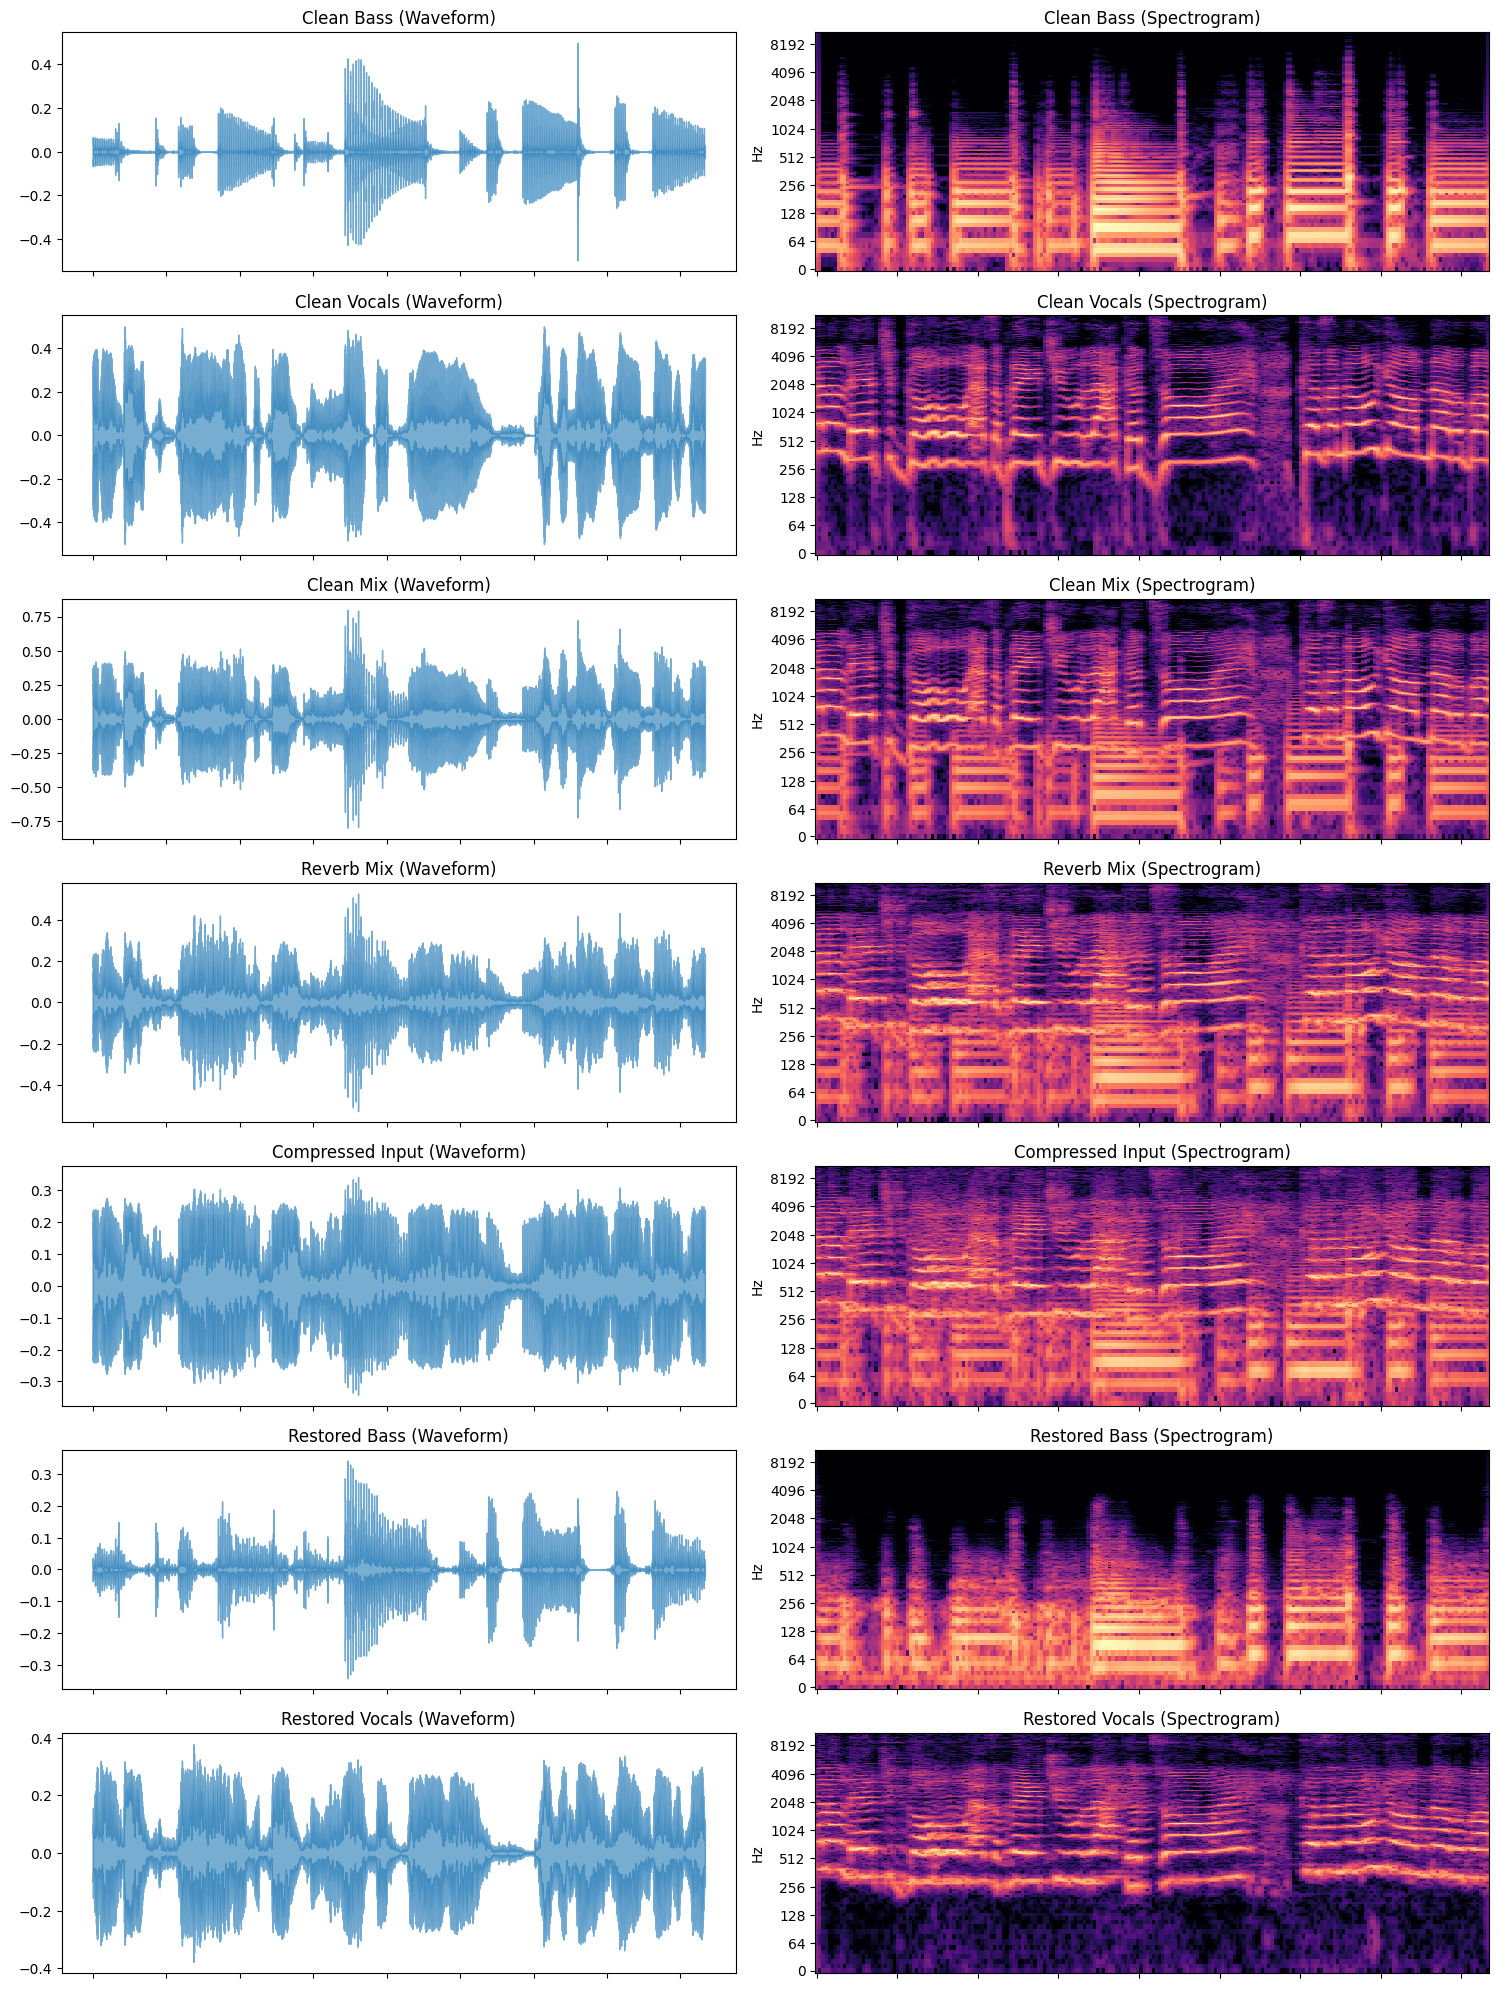

In [ ]:

import os
import glob
import torch
import soundfile as sf
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# --- CONFIG ---
# We pick the first file in the dataset to visualize
FILE_ID = "mix_0000.wav"
DATA_ROOT = "synthetic_dataset"
MODEL_PATH = "advanced_unet_final.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def plot_waveform_and_spec(ax_wave, ax_spec, audio, sr, title):
    """Helper to plot wave and spec side-by-side"""
    # Waveform
    librosa.display.waveshow(audio, sr=sr, ax=ax_wave, alpha=0.6)
    ax_wave.set_title(f"{title} (Waveform)")
    ax_wave.set_xlabel("")
    ax_wave.set_xticklabels([])

    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=ax_spec)
    ax_spec.set_title(f"{title} (Spectrogram)")
    ax_spec.set_xlabel("")
    ax_spec.set_xticklabels([])

def run_inspection():
    print(f"--- Visualizing Pipeline for {FILE_ID} ---")

    # 1. Load Files (Ground Truths & Intermediate Steps)
    # Based on dataset_generator.py structure:
    # cat1 = Clean Mix, cat2 = Reverb, cat4 = Reverb+Comp (Input)
    paths = {
        "Clean Bass": f"{DATA_ROOT}/targets/bass/{FILE_ID}",
        "Clean Vocals": f"{DATA_ROOT}/targets/vocals/{FILE_ID}",
        "Clean Mix": f"{DATA_ROOT}/targets/mix/{FILE_ID}",
        "Reverb Mix": f"{DATA_ROOT}/inputs/cat2_reverb/{FILE_ID}",
        "Compressed Input": f"{DATA_ROOT}/inputs/cat4_both/{FILE_ID}", # This is what model sees
    }

    audio_data = {}
    sr = 22050

    for name, path in paths.items():
        if os.path.exists(path):
            sig, sr = sf.read(path)
            audio_data[name] = sig
        else:
            print(f"Warning: {path} not found.")
            return

    # 2. Run Model Inference
    print("Running Model Inference...")
    model = ImprovedMelUNet().to(DEVICE)
    if os.path.exists(MODEL_PATH):
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    else:
        print("Model weights not found. Using random weights for demo.")

    model.eval()

    # Prepare Input
    input_sig = audio_data["Compressed Input"]
    input_tens = torch.from_numpy(input_sig).float()
    if input_tens.ndim == 1: input_tens = input_tens.unsqueeze(0)
    input_tens = input_tens.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        bass_out, vocal_out, _, _ = model(input_tens)

    audio_data["Restored Bass"] = bass_out.squeeze().cpu().numpy()
    audio_data["Restored Vocals"] = vocal_out.squeeze().cpu().numpy()

    # 3. Plotting
    # Layout: 7 Rows (Signals), 2 Cols (Wave, Spec)
    fig, axes = plt.subplots(7, 2, figsize=(15, 20))

    # Order of visualization
    order = [
        "Clean Bass", "Clean Vocals",
        "Clean Mix", "Reverb Mix", "Compressed Input",
        "Restored Bass", "Restored Vocals"
    ]

    for i, name in enumerate(order):
        if name in audio_data:
            plot_waveform_and_spec(axes[i, 0], axes[i, 1], audio_data[name], sr, name)

    plt.tight_layout()
    plt.savefig("pipeline_visual_inspection.png")
    print("Saved visualization to 'pipeline_visual_inspection.png'")

    # Try to display in notebook
    try:
        plt.show()
    except:
        pass

if __name__ == "__main__":
    run_inspection()

In [ ]:
import os
import torch
import soundfile as sf
import torchaudio
import numpy as np

# --- CONFIG ---
WEIGHTS_FILE = "advanced_unet_final.pth" # Ensure this file exists
INPUT_AUDIO = "synthetic_dataset/inputs/cat4_both/mix_0000.wav" # Replace with any file path
OUTPUT_DIR = "final_predictions"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAMPLE_RATE = 22050

def separate_audio(input_path, model, output_folder):
    filename = os.path.basename(input_path)
    print(f"Processing: {filename}")

    # Load
    sig, sr = sf.read(input_path)
    tens = torch.from_numpy(sig).float()

    # Preprocess (Mono, Resample, Shape)
    if tens.ndim > 1: tens = tens.mean(dim=1) if tens.shape[1] < tens.shape[0] else tens.mean(dim=0)
    if tens.ndim == 1: tens = tens.unsqueeze(0)
    if sr != SAMPLE_RATE:
        resampler = torchaudio.transforms.Resample(sr, SAMPLE_RATE)
        tens = resampler(tens)

    # Inference
    tens = tens.unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        bass_out, vocal_out, _, _ = model(tens)

    # Save
    bass_np = bass_out.squeeze().cpu().numpy()
    vocal_np = vocal_out.squeeze().cpu().numpy()

    os.makedirs(output_folder, exist_ok=True)
    sf.write(f"{output_folder}/bass_{filename}", bass_np, SAMPLE_RATE)
    sf.write(f"{output_folder}/vocals_{filename}", vocal_np, SAMPLE_RATE)
    print(f"Saved to {output_folder}/")

def main():
    if not os.path.exists(WEIGHTS_FILE):
        print(f"CRITICAL ERROR: Weights file '{WEIGHTS_FILE}' not found.")
        print("Please run the training script first or upload the .pth file.")
        return

    # 1. Initialize Model
    print("Loading Model...")
    model = ImprovedMelUNet().to(DEVICE)

    # 2. Load Weights
    state_dict = torch.load(WEIGHTS_FILE, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.eval()
    print("Weights loaded successfully!")

    # 3. Run on a specific file
    if os.path.exists(INPUT_AUDIO):
        separate_audio(INPUT_AUDIO, model, OUTPUT_DIR)
    else:
        print(f"Input file {INPUT_AUDIO} not found.")

if __name__ == "__main__":
    main()

Loading Model...
Weights loaded successfully!
Processing: mix_0000.wav
Saved to final_predictions/


Plot saved to 'training_loss_curves_manual.png'


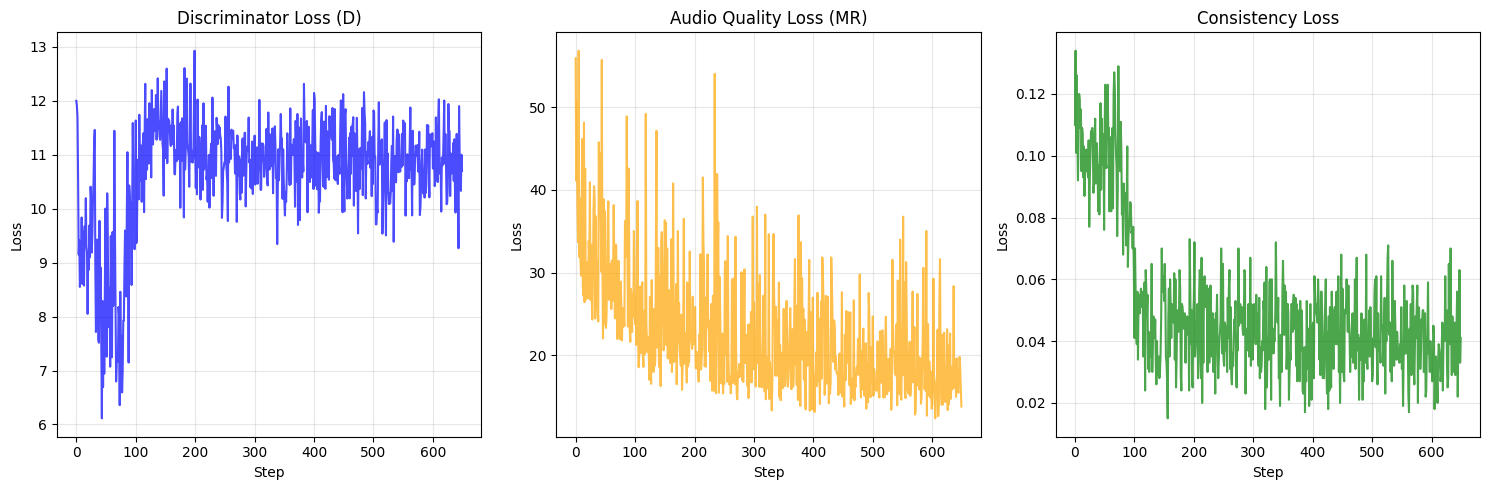

In [ ]:
import matplotlib.pyplot as plt
import re

# Paste your log output here
LOG_DATA = """
Ep 0 [0] D:11.999 MR:55.941 Consist:0.110
Ep 0 [10] D:11.903 MR:41.109 Consist:0.134
Ep 0 [20] D:11.703 MR:50.736 Consist:0.101
Ep 0 [30] D:10.551 MR:38.088 Consist:0.126
Ep 0 [40] D:9.152 MR:33.674 Consist:0.108
Ep 0 [50] D:9.410 MR:56.858 Consist:0.092
Ep 0 [60] D:8.550 MR:31.882 Consist:0.107
Ep 0 [70] D:8.819 MR:38.961 Consist:0.120
Ep 0 [80] D:8.851 MR:31.645 Consist:0.118
Ep 0 [90] D:9.838 MR:29.620 Consist:0.109
Ep 0 [100] D:8.605 MR:35.816 Consist:0.115
Ep 0 [110] D:9.584 MR:46.175 Consist:0.095
Ep 0 [120] D:8.654 MR:28.453 Consist:0.109
Ep 1 [0] D:8.574 MR:27.206 Consist:0.107
Ep 1 [10] D:9.674 MR:48.132 Consist:0.093
Ep 1 [20] D:9.449 MR:26.419 Consist:0.103
Ep 1 [30] D:10.195 MR:42.574 Consist:0.087
Ep 1 [40] D:9.305 MR:26.729 Consist:0.095
Ep 1 [50] D:9.196 MR:28.826 Consist:0.095
Ep 1 [60] D:8.051 MR:29.321 Consist:0.102
Ep 1 [70] D:9.186 MR:31.257 Consist:0.098
Ep 1 [80] D:8.868 MR:26.895 Consist:0.096
Ep 1 [90] D:9.689 MR:33.829 Consist:0.093
Ep 1 [100] D:9.100 MR:31.807 Consist:0.105
Ep 1 [110] D:10.409 MR:40.926 Consist:0.077
Ep 1 [120] D:10.162 MR:26.713 Consist:0.093
Ep 2 [0] D:9.188 MR:33.395 Consist:0.100
Ep 2 [10] D:9.523 MR:27.182 Consist:0.108
Ep 2 [20] D:10.143 MR:24.316 Consist:0.105
Ep 2 [30] D:10.519 MR:28.638 Consist:0.109
Ep 2 [40] D:11.235 MR:37.474 Consist:0.105
Ep 2 [50] D:11.461 MR:40.461 Consist:0.088
Ep 2 [60] D:8.915 MR:38.852 Consist:0.091
Ep 2 [70] D:7.715 MR:24.435 Consist:0.107
Ep 2 [80] D:8.041 MR:36.815 Consist:0.112
Ep 2 [90] D:9.429 MR:25.947 Consist:0.091
Ep 2 [100] D:8.968 MR:31.315 Consist:0.092
Ep 2 [110] D:7.571 MR:25.924 Consist:0.104
Ep 2 [120] D:7.515 MR:24.079 Consist:0.097
Ep 3 [0] D:9.775 MR:45.783 Consist:0.082
Ep 3 [10] D:8.003 MR:36.598 Consist:0.097
Ep 3 [20] D:8.908 MR:44.500 Consist:0.081
Ep 3 [30] D:7.610 MR:38.917 Consist:0.097
Ep 3 [40] D:6.114 MR:30.114 Consist:0.117
Ep 3 [50] D:8.291 MR:55.750 Consist:0.089
Ep 3 [60] D:6.693 MR:31.411 Consist:0.112
Ep 3 [70] D:8.158 MR:22.029 Consist:0.097
Ep 3 [80] D:6.943 MR:38.890 Consist:0.107
Ep 3 [90] D:8.390 MR:23.721 Consist:0.105
Ep 3 [100] D:10.003 MR:37.467 Consist:0.076
Ep 3 [110] D:8.143 MR:25.089 Consist:0.111
Ep 3 [120] D:7.258 MR:23.299 Consist:0.123
Ep 4 [0] D:10.286 MR:24.694 Consist:0.098
Ep 4 [10] D:9.184 MR:30.626 Consist:0.096
Ep 4 [20] D:8.276 MR:36.438 Consist:0.113
Ep 4 [30] D:7.804 MR:38.627 Consist:0.123
Ep 4 [40] D:8.525 MR:26.692 Consist:0.108
Ep 4 [50] D:7.071 MR:28.653 Consist:0.109
Ep 4 [60] D:9.493 MR:31.020 Consist:0.082
Ep 4 [70] D:8.344 MR:29.271 Consist:0.105
Ep 4 [80] D:7.245 MR:25.589 Consist:0.106
Ep 4 [90] D:9.568 MR:31.469 Consist:0.082
Ep 4 [100] D:8.197 MR:26.563 Consist:0.103
Ep 4 [110] D:8.758 MR:29.165 Consist:0.109
Ep 4 [120] D:11.445 MR:38.166 Consist:0.083
Ep 5 [0] D:9.612 MR:31.453 Consist:0.120
Ep 5 [10] D:8.306 MR:24.459 Consist:0.127
Ep 5 [20] D:6.796 MR:25.542 Consist:0.122
Ep 5 [30] D:7.174 MR:33.373 Consist:0.108
Ep 5 [40] D:7.213 MR:30.187 Consist:0.101
Ep 5 [50] D:7.169 MR:21.956 Consist:0.096
Ep 5 [60] D:8.179 MR:24.486 Consist:0.074
Ep 5 [70] D:8.015 MR:31.409 Consist:0.090
Ep 5 [80] D:6.358 MR:27.722 Consist:0.129
Ep 5 [90] D:8.460 MR:22.115 Consist:0.101
Ep 5 [100] D:7.138 MR:21.915 Consist:0.101
Ep 5 [110] D:7.647 MR:28.916 Consist:0.095
Ep 5 [120] D:6.595 MR:25.270 Consist:0.111
Ep 6 [0] D:6.988 MR:21.776 Consist:0.102
Ep 6 [10] D:7.925 MR:25.714 Consist:0.081
Ep 6 [20] D:7.925 MR:23.459 Consist:0.086
Ep 6 [30] D:8.908 MR:24.747 Consist:0.068
Ep 6 [40] D:9.596 MR:23.521 Consist:0.091
Ep 6 [50] D:8.957 MR:36.243 Consist:0.085
Ep 6 [60] D:8.374 MR:33.126 Consist:0.088
Ep 6 [70] D:9.962 MR:31.904 Consist:0.087
Ep 6 [80] D:11.048 MR:48.918 Consist:0.071
Ep 6 [90] D:9.496 MR:33.594 Consist:0.084
Ep 6 [100] D:7.148 MR:23.465 Consist:0.103
Ep 6 [110] D:10.430 MR:42.594 Consist:0.064
Ep 6 [120] D:10.195 MR:34.185 Consist:0.074
Ep 7 [0] D:9.857 MR:23.012 Consist:0.077
Ep 7 [10] D:10.122 MR:21.621 Consist:0.078
Ep 7 [20] D:8.586 MR:28.021 Consist:0.085
Ep 7 [30] D:10.208 MR:26.856 Consist:0.084
Ep 7 [40] D:11.589 MR:22.804 Consist:0.075
Ep 7 [50] D:10.471 MR:27.376 Consist:0.076
Ep 7 [60] D:10.125 MR:24.680 Consist:0.070
Ep 7 [70] D:9.249 MR:35.034 Consist:0.077
Ep 7 [80] D:10.104 MR:31.093 Consist:0.063
Ep 7 [90] D:11.635 MR:23.781 Consist:0.041
Ep 7 [100] D:9.362 MR:27.079 Consist:0.070
Ep 7 [110] D:9.501 MR:21.248 Consist:0.056
Ep 7 [120] D:10.673 MR:22.589 Consist:0.043
Ep 8 [0] D:10.910 MR:38.666 Consist:0.039
Ep 8 [10] D:10.174 MR:22.407 Consist:0.056
Ep 8 [20] D:11.742 MR:18.545 Consist:0.034
Ep 8 [30] D:10.521 MR:19.983 Consist:0.055
Ep 8 [40] D:11.182 MR:26.153 Consist:0.054
Ep 8 [50] D:10.910 MR:28.331 Consist:0.049
Ep 8 [60] D:10.128 MR:20.285 Consist:0.054
Ep 8 [70] D:10.771 MR:21.517 Consist:0.057
Ep 8 [80] D:11.239 MR:28.844 Consist:0.051
Ep 8 [90] D:11.398 MR:20.155 Consist:0.056
Ep 8 [100] D:9.937 MR:18.595 Consist:0.055
Ep 8 [110] D:11.407 MR:25.388 Consist:0.035
Ep 8 [120] D:12.315 MR:24.810 Consist:0.041
Ep 9 [0] D:10.548 MR:20.160 Consist:0.059
Ep 9 [10] D:11.487 MR:49.214 Consist:0.024
Ep 9 [20] D:10.723 MR:23.793 Consist:0.063
Ep 9 [30] D:11.662 MR:21.725 Consist:0.057
Ep 9 [40] D:11.406 MR:20.419 Consist:0.048
Ep 9 [50] D:10.837 MR:22.199 Consist:0.055
Ep 9 [60] D:11.956 MR:20.449 Consist:0.031
Ep 9 [70] D:11.218 MR:17.012 Consist:0.043
Ep 9 [80] D:11.678 MR:27.052 Consist:0.030
Ep 9 [90] D:10.579 MR:18.215 Consist:0.041
Ep 9 [100] D:12.199 MR:16.535 Consist:0.035
Ep 9 [110] D:11.445 MR:29.096 Consist:0.042
Ep 9 [120] D:11.191 MR:19.660 Consist:0.065
Ep 10 [0] D:11.456 MR:21.085 Consist:0.030
Ep 10 [10] D:11.847 MR:17.967 Consist:0.040
Ep 10 [20] D:11.441 MR:25.633 Consist:0.048
Ep 10 [30] D:11.463 MR:18.697 Consist:0.041
Ep 10 [40] D:12.108 MR:19.273 Consist:0.041
Ep 10 [50] D:11.280 MR:34.076 Consist:0.047
Ep 10 [60] D:11.503 MR:47.167 Consist:0.032
Ep 10 [70] D:12.417 MR:20.924 Consist:0.026
Ep 10 [80] D:11.642 MR:22.331 Consist:0.040
Ep 10 [90] D:11.575 MR:32.990 Consist:0.029
Ep 10 [100] D:11.341 MR:19.825 Consist:0.035
Ep 10 [110] D:11.278 MR:18.533 Consist:0.035
Ep 10 [120] D:11.739 MR:29.625 Consist:0.028
Ep 11 [0] D:12.185 MR:16.254 Consist:0.030
Ep 11 [10] D:11.712 MR:33.741 Consist:0.036
Ep 11 [20] D:11.206 MR:34.905 Consist:0.047
Ep 11 [30] D:11.086 MR:30.593 Consist:0.070
Ep 11 [40] D:10.242 MR:24.365 Consist:0.058
Ep 11 [50] D:12.359 MR:20.589 Consist:0.056
Ep 11 [60] D:11.325 MR:21.957 Consist:0.061
Ep 11 [70] D:11.035 MR:36.333 Consist:0.053
Ep 11 [80] D:10.937 MR:21.452 Consist:0.065
Ep 11 [90] D:12.597 MR:36.051 Consist:0.056
Ep 11 [100] D:10.845 MR:21.192 Consist:0.035
Ep 11 [110] D:11.673 MR:32.913 Consist:0.033
Ep 11 [120] D:11.433 MR:19.600 Consist:0.027
Ep 12 [0] D:11.643 MR:24.123 Consist:0.015
Ep 12 [10] D:11.534 MR:27.874 Consist:0.047
Ep 12 [20] D:11.268 MR:22.778 Consist:0.057
Ep 12 [30] D:11.162 MR:19.069 Consist:0.035
Ep 12 [40] D:11.541 MR:20.936 Consist:0.060
Ep 12 [50] D:11.194 MR:34.036 Consist:0.052
Ep 12 [60] D:11.840 MR:17.966 Consist:0.041
Ep 12 [70] D:11.349 MR:20.800 Consist:0.052
Ep 12 [80] D:11.541 MR:40.812 Consist:0.050
Ep 12 [90] D:10.648 MR:25.500 Consist:0.050
Ep 12 [100] D:10.636 MR:19.178 Consist:0.046
Ep 12 [110] D:10.996 MR:19.534 Consist:0.062
Ep 12 [120] D:11.092 MR:23.602 Consist:0.034
Ep 13 [0] D:10.882 MR:28.595 Consist:0.060
Ep 13 [10] D:11.762 MR:16.489 Consist:0.025
Ep 13 [20] D:11.895 MR:23.083 Consist:0.034
Ep 13 [30] D:10.918 MR:35.028 Consist:0.050
Ep 13 [40] D:11.569 MR:21.519 Consist:0.043
Ep 13 [50] D:11.326 MR:26.305 Consist:0.043
Ep 13 [60] D:10.018 MR:20.579 Consist:0.049
Ep 13 [70] D:11.607 MR:19.820 Consist:0.063
Ep 13 [80] D:10.884 MR:18.729 Consist:0.057
Ep 13 [90] D:11.676 MR:24.905 Consist:0.029
Ep 13 [100] D:11.488 MR:15.799 Consist:0.024
Ep 13 [110] D:11.175 MR:18.538 Consist:0.052
Ep 13 [120] D:9.838 MR:23.623 Consist:0.051
Ep 14 [0] D:12.607 MR:36.514 Consist:0.048
Ep 14 [10] D:10.727 MR:18.976 Consist:0.044
Ep 14 [20] D:11.050 MR:22.714 Consist:0.047
Ep 14 [30] D:11.385 MR:21.719 Consist:0.049
Ep 14 [40] D:12.412 MR:19.974 Consist:0.033
Ep 14 [50] D:11.217 MR:16.695 Consist:0.045
Ep 14 [60] D:11.095 MR:28.808 Consist:0.042
Ep 14 [70] D:10.976 MR:18.621 Consist:0.048
Ep 14 [80] D:10.407 MR:19.046 Consist:0.047
Ep 14 [90] D:11.249 MR:19.308 Consist:0.046
Ep 14 [100] D:12.320 MR:32.554 Consist:0.024
Ep 14 [110] D:11.119 MR:21.842 Consist:0.073
Ep 14 [120] D:10.864 MR:22.850 Consist:0.056
Ep 15 [0] D:11.074 MR:21.692 Consist:0.039
Ep 15 [10] D:10.856 MR:20.773 Consist:0.050
Ep 15 [20] D:10.997 MR:27.080 Consist:0.027
Ep 15 [30] D:11.985 MR:21.311 Consist:0.025
Ep 15 [40] D:12.929 MR:25.368 Consist:0.048
Ep 15 [50] D:11.079 MR:24.548 Consist:0.054
Ep 15 [60] D:10.388 MR:25.835 Consist:0.072
Ep 15 [70] D:10.789 MR:18.482 Consist:0.035
Ep 15 [80] D:10.267 MR:18.392 Consist:0.039
Ep 15 [90] D:12.024 MR:20.395 Consist:0.046
Ep 15 [100] D:11.223 MR:19.739 Consist:0.041
Ep 15 [110] D:10.766 MR:18.208 Consist:0.052
Ep 15 [120] D:11.328 MR:16.801 Consist:0.028
Ep 16 [0] D:11.074 MR:22.474 Consist:0.033
Ep 16 [10] D:10.170 MR:21.944 Consist:0.056
Ep 16 [20] D:11.100 MR:32.224 Consist:0.063
Ep 16 [30] D:10.970 MR:18.260 Consist:0.055
Ep 16 [40] D:11.549 MR:19.714 Consist:0.028
Ep 16 [50] D:10.349 MR:20.723 Consist:0.067
Ep 16 [60] D:11.954 MR:41.519 Consist:0.020
Ep 16 [70] D:10.726 MR:33.670 Consist:0.052
Ep 16 [80] D:11.364 MR:30.991 Consist:0.033
Ep 16 [90] D:11.240 MR:18.667 Consist:0.056
Ep 16 [100] D:11.538 MR:19.124 Consist:0.061
Ep 16 [110] D:10.541 MR:18.607 Consist:0.053
Ep 16 [120] D:10.623 MR:27.021 Consist:0.051
Ep 17 [0] D:10.128 MR:25.382 Consist:0.057
Ep 17 [10] D:10.566 MR:32.200 Consist:0.058
Ep 17 [20] D:10.995 MR:23.333 Consist:0.030
Ep 17 [30] D:10.020 MR:23.623 Consist:0.057
Ep 17 [40] D:10.582 MR:20.382 Consist:0.049
Ep 17 [50] D:11.035 MR:24.219 Consist:0.033
Ep 17 [60] D:11.205 MR:16.882 Consist:0.042
Ep 17 [70] D:10.569 MR:26.193 Consist:0.058
Ep 17 [80] D:12.061 MR:23.330 Consist:0.049
Ep 17 [90] D:10.995 MR:15.706 Consist:0.035
Ep 17 [100] D:10.239 MR:27.195 Consist:0.048
Ep 17 [110] D:11.085 MR:17.976 Consist:0.049
Ep 17 [120] D:11.435 MR:15.696 Consist:0.030
Ep 18 [0] D:11.229 MR:54.062 Consist:0.047
Ep 18 [10] D:10.609 MR:18.713 Consist:0.037
Ep 18 [20] D:11.685 MR:15.400 Consist:0.023
Ep 18 [30] D:11.447 MR:21.153 Consist:0.049
Ep 18 [40] D:11.198 MR:41.938 Consist:0.044
Ep 18 [50] D:11.550 MR:32.048 Consist:0.055
Ep 18 [60] D:11.310 MR:36.083 Consist:0.037
Ep 18 [70] D:11.508 MR:15.449 Consist:0.028
Ep 18 [80] D:11.365 MR:29.508 Consist:0.034
Ep 18 [90] D:11.303 MR:26.155 Consist:0.040
Ep 18 [100] D:11.069 MR:20.890 Consist:0.043
Ep 18 [110] D:9.830 MR:16.588 Consist:0.047
Ep 18 [120] D:10.102 MR:22.499 Consist:0.070
Ep 19 [0] D:10.697 MR:22.619 Consist:0.046
Ep 19 [10] D:10.755 MR:15.359 Consist:0.036
Ep 19 [20] D:10.853 MR:17.343 Consist:0.065
Ep 19 [30] D:10.856 MR:16.516 Consist:0.034
Ep 19 [40] D:11.709 MR:30.470 Consist:0.032
Ep 19 [50] D:10.878 MR:31.393 Consist:0.046
Ep 19 [60] D:10.677 MR:20.047 Consist:0.045
Ep 19 [70] D:10.487 MR:29.011 Consist:0.037
Ep 19 [80] D:9.772 MR:16.793 Consist:0.043
Ep 19 [90] D:12.263 MR:34.425 Consist:0.030
Ep 19 [100] D:10.857 MR:20.532 Consist:0.054
Ep 19 [110] D:11.065 MR:16.465 Consist:0.041
Ep 19 [120] D:11.077 MR:17.449 Consist:0.058
Ep 20 [0] D:10.923 MR:17.289 Consist:0.063
Ep 20 [10] D:11.465 MR:15.372 Consist:0.031
Ep 20 [20] D:11.290 MR:16.738 Consist:0.051
Ep 20 [30] D:11.439 MR:29.154 Consist:0.029
Ep 20 [40] D:11.447 MR:16.654 Consist:0.026
Ep 20 [50] D:11.120 MR:19.765 Consist:0.036
Ep 20 [60] D:11.159 MR:29.307 Consist:0.032
Ep 20 [70] D:10.653 MR:20.883 Consist:0.041
Ep 20 [80] D:11.178 MR:16.488 Consist:0.047
Ep 20 [90] D:11.026 MR:34.340 Consist:0.043
Ep 20 [100] D:9.755 MR:20.487 Consist:0.053
Ep 20 [110] D:11.358 MR:15.267 Consist:0.030
Ep 20 [120] D:10.607 MR:14.660 Consist:0.025
Ep 21 [0] D:10.612 MR:17.898 Consist:0.042
Ep 21 [10] D:10.970 MR:17.254 Consist:0.037
Ep 21 [20] D:10.289 MR:18.930 Consist:0.070
Ep 21 [30] D:10.170 MR:17.921 Consist:0.045
Ep 21 [40] D:10.910 MR:18.750 Consist:0.047
Ep 21 [50] D:10.294 MR:17.423 Consist:0.052
Ep 21 [60] D:11.258 MR:30.043 Consist:0.046
Ep 21 [70] D:11.303 MR:16.987 Consist:0.047
Ep 21 [80] D:10.611 MR:21.591 Consist:0.051
Ep 21 [90] D:10.820 MR:16.751 Consist:0.044
Ep 21 [100] D:11.405 MR:23.151 Consist:0.042
Ep 21 [110] D:11.407 MR:30.398 Consist:0.044
Ep 21 [120] D:10.043 MR:19.061 Consist:0.063
Ep 22 [0] D:10.683 MR:20.720 Consist:0.062
Ep 22 [10] D:11.108 MR:22.442 Consist:0.023
Ep 22 [20] D:11.156 MR:19.029 Consist:0.044
Ep 22 [30] D:11.079 MR:16.283 Consist:0.039
Ep 22 [40] D:11.690 MR:23.671 Consist:0.037
Ep 22 [50] D:10.859 MR:14.812 Consist:0.039
Ep 22 [60] D:10.908 MR:23.714 Consist:0.052
Ep 22 [70] D:10.397 MR:16.766 Consist:0.035
Ep 22 [80] D:10.757 MR:18.238 Consist:0.040
Ep 22 [90] D:10.374 MR:25.234 Consist:0.067
Ep 22 [100] D:11.246 MR:16.714 Consist:0.032
Ep 22 [110] D:10.273 MR:20.989 Consist:0.052
Ep 22 [120] D:11.027 MR:36.784 Consist:0.044
Ep 23 [0] D:10.604 MR:18.304 Consist:0.034
Ep 23 [10] D:11.355 MR:26.371 Consist:0.048
Ep 23 [20] D:10.447 MR:19.408 Consist:0.050
Ep 23 [30] D:10.872 MR:19.128 Consist:0.052
Ep 23 [40] D:10.727 MR:16.208 Consist:0.043
Ep 23 [50] D:11.138 MR:20.155 Consist:0.039
Ep 23 [60] D:10.462 MR:37.987 Consist:0.055
Ep 23 [70] D:10.717 MR:19.022 Consist:0.045
Ep 23 [80] D:10.893 MR:22.468 Consist:0.049
Ep 23 [90] D:12.018 MR:28.640 Consist:0.036
Ep 23 [100] D:11.121 MR:16.174 Consist:0.032
Ep 23 [110] D:10.350 MR:29.704 Consist:0.054
Ep 23 [120] D:10.350 MR:20.107 Consist:0.028
Ep 24 [0] D:11.210 MR:16.361 Consist:0.038
Ep 24 [10] D:10.882 MR:16.105 Consist:0.030
Ep 24 [20] D:11.205 MR:17.431 Consist:0.032
Ep 24 [30] D:11.159 MR:21.511 Consist:0.040
Ep 24 [40] D:10.590 MR:27.201 Consist:0.037
Ep 24 [50] D:10.719 MR:17.368 Consist:0.053
Ep 24 [60] D:10.917 MR:15.629 Consist:0.050
Ep 24 [70] D:10.968 MR:37.016 Consist:0.059
Ep 24 [80] D:11.480 MR:14.659 Consist:0.018
Ep 24 [90] D:10.508 MR:19.795 Consist:0.037
Ep 24 [100] D:10.431 MR:18.409 Consist:0.064
Ep 24 [110] D:11.784 MR:15.978 Consist:0.025
Ep 24 [120] D:10.934 MR:16.181 Consist:0.041
Ep 25 [0] D:10.726 MR:34.660 Consist:0.040
Ep 25 [10] D:11.377 MR:14.688 Consist:0.034
Ep 25 [20] D:10.860 MR:19.134 Consist:0.059
Ep 25 [30] D:11.228 MR:17.487 Consist:0.060
Ep 25 [40] D:10.787 MR:16.427 Consist:0.055
Ep 25 [50] D:11.489 MR:13.307 Consist:0.021
Ep 25 [60] D:10.287 MR:17.018 Consist:0.060
Ep 25 [70] D:11.017 MR:29.351 Consist:0.039
Ep 25 [80] D:10.877 MR:34.664 Consist:0.044
Ep 25 [90] D:11.528 MR:26.843 Consist:0.036
Ep 25 [100] D:11.178 MR:24.600 Consist:0.041
Ep 25 [110] D:10.567 MR:17.520 Consist:0.040
Ep 25 [120] D:10.616 MR:25.843 Consist:0.049
Ep 26 [0] D:9.344 MR:18.830 Consist:0.072
Ep 26 [10] D:10.395 MR:17.507 Consist:0.054
Ep 26 [20] D:11.101 MR:24.198 Consist:0.053
Ep 26 [30] D:10.529 MR:21.450 Consist:0.046
Ep 26 [40] D:10.859 MR:28.791 Consist:0.054
Ep 26 [50] D:11.262 MR:14.920 Consist:0.028
Ep 26 [60] D:11.756 MR:21.262 Consist:0.032
Ep 26 [70] D:11.200 MR:14.548 Consist:0.019
Ep 26 [80] D:11.300 MR:19.790 Consist:0.042
Ep 26 [90] D:10.184 MR:20.297 Consist:0.038
Ep 26 [100] D:11.101 MR:15.978 Consist:0.030
Ep 26 [110] D:10.514 MR:19.218 Consist:0.056
Ep 26 [120] D:10.150 MR:25.608 Consist:0.066
Ep 27 [0] D:9.874 MR:18.656 Consist:0.055
Ep 27 [10] D:10.302 MR:16.265 Consist:0.042
Ep 27 [20] D:10.130 MR:16.728 Consist:0.058
Ep 27 [30] D:10.566 MR:25.634 Consist:0.048
Ep 27 [40] D:11.398 MR:26.574 Consist:0.056
Ep 27 [50] D:10.899 MR:21.393 Consist:0.031
Ep 27 [60] D:10.964 MR:16.187 Consist:0.037
Ep 27 [70] D:10.620 MR:17.088 Consist:0.052
Ep 27 [80] D:10.438 MR:18.812 Consist:0.049
Ep 27 [90] D:11.860 MR:22.114 Consist:0.021
Ep 27 [100] D:10.457 MR:25.716 Consist:0.030
Ep 27 [110] D:11.186 MR:22.023 Consist:0.036
Ep 27 [120] D:11.109 MR:15.886 Consist:0.034
Ep 28 [0] D:10.995 MR:18.479 Consist:0.052
Ep 28 [10] D:11.132 MR:23.148 Consist:0.052
Ep 28 [20] D:11.290 MR:16.188 Consist:0.043
Ep 28 [30] D:10.943 MR:17.978 Consist:0.053
Ep 28 [40] D:10.037 MR:26.704 Consist:0.055
Ep 28 [50] D:11.629 MR:31.638 Consist:0.053
Ep 28 [60] D:10.774 MR:18.850 Consist:0.044
Ep 28 [70] D:10.504 MR:24.328 Consist:0.054
Ep 28 [80] D:11.756 MR:16.407 Consist:0.032
Ep 28 [90] D:9.699 MR:26.017 Consist:0.052
Ep 28 [100] D:11.509 MR:14.577 Consist:0.027
Ep 28 [110] D:10.466 MR:36.933 Consist:0.050
Ep 28 [120] D:9.788 MR:19.246 Consist:0.036
Ep 29 [0] D:10.871 MR:21.320 Consist:0.036
Ep 29 [10] D:11.672 MR:13.857 Consist:0.027
Ep 29 [20] D:10.814 MR:33.684 Consist:0.053
Ep 29 [30] D:10.577 MR:19.570 Consist:0.037
Ep 29 [40] D:10.918 MR:29.314 Consist:0.050
Ep 29 [50] D:10.692 MR:19.475 Consist:0.047
Ep 29 [60] D:12.314 MR:25.652 Consist:0.024
Ep 29 [70] D:11.583 MR:17.029 Consist:0.023
Ep 29 [80] D:11.602 MR:24.336 Consist:0.028
Ep 29 [90] D:11.230 MR:15.800 Consist:0.038
Ep 29 [100] D:11.531 MR:13.443 Consist:0.017
Ep 29 [110] D:11.627 MR:22.800 Consist:0.038
Ep 29 [120] D:9.934 MR:19.706 Consist:0.027
Ep 30 [0] D:11.328 MR:18.732 Consist:0.053
Ep 30 [10] D:11.519 MR:21.729 Consist:0.031
Ep 30 [20] D:11.076 MR:24.856 Consist:0.035
Ep 30 [30] D:10.496 MR:31.536 Consist:0.044
Ep 30 [40] D:11.074 MR:13.279 Consist:0.019
Ep 30 [50] D:11.179 MR:25.243 Consist:0.040
Ep 30 [60] D:10.578 MR:17.478 Consist:0.052
Ep 30 [70] D:11.193 MR:20.758 Consist:0.041
Ep 30 [80] D:11.829 MR:13.438 Consist:0.021
Ep 30 [90] D:10.366 MR:26.972 Consist:0.045
Ep 30 [100] D:12.146 MR:15.917 Consist:0.030
Ep 30 [110] D:12.033 MR:16.171 Consist:0.046
Ep 30 [120] D:11.258 MR:13.126 Consist:0.028
Ep 31 [0] D:10.429 MR:17.222 Consist:0.061
Ep 31 [10] D:11.048 MR:18.062 Consist:0.054
Ep 31 [20] D:10.361 MR:20.373 Consist:0.049
Ep 31 [30] D:10.370 MR:16.262 Consist:0.052
Ep 31 [40] D:11.039 MR:27.565 Consist:0.048
Ep 31 [50] D:9.925 MR:16.884 Consist:0.046
Ep 31 [60] D:10.250 MR:24.429 Consist:0.060
Ep 31 [70] D:10.135 MR:17.862 Consist:0.053
Ep 31 [80] D:11.191 MR:14.096 Consist:0.034
Ep 31 [90] D:11.634 MR:22.414 Consist:0.047
Ep 31 [100] D:11.791 MR:26.534 Consist:0.029
Ep 31 [110] D:11.035 MR:17.158 Consist:0.056
Ep 31 [120] D:10.512 MR:31.842 Consist:0.056
Ep 32 [0] D:10.404 MR:29.975 Consist:0.048
Ep 32 [10] D:11.614 MR:26.363 Consist:0.028
Ep 32 [20] D:11.161 MR:23.664 Consist:0.032
Ep 32 [30] D:10.369 MR:15.202 Consist:0.028
Ep 32 [40] D:11.906 MR:18.337 Consist:0.043
Ep 32 [50] D:10.658 MR:27.179 Consist:0.052
Ep 32 [60] D:10.592 MR:16.550 Consist:0.060
Ep 32 [70] D:11.256 MR:20.773 Consist:0.032
Ep 32 [80] D:11.441 MR:27.095 Consist:0.023
Ep 32 [90] D:10.538 MR:22.355 Consist:0.043
Ep 32 [100] D:11.716 MR:14.167 Consist:0.018
Ep 32 [110] D:11.343 MR:18.274 Consist:0.048
Ep 32 [120] D:11.426 MR:15.320 Consist:0.024
Ep 33 [0] D:11.483 MR:16.713 Consist:0.051
Ep 33 [10] D:11.280 MR:31.839 Consist:0.029
Ep 33 [20] D:11.867 MR:29.201 Consist:0.025
Ep 33 [30] D:10.907 MR:25.467 Consist:0.056
Ep 33 [40] D:10.848 MR:19.197 Consist:0.044
Ep 33 [50] D:10.560 MR:19.303 Consist:0.040
Ep 33 [60] D:11.847 MR:24.208 Consist:0.031
Ep 33 [70] D:10.532 MR:23.147 Consist:0.050
Ep 33 [80] D:10.524 MR:18.282 Consist:0.051
Ep 33 [90] D:10.822 MR:19.769 Consist:0.051
Ep 33 [100] D:10.969 MR:17.835 Consist:0.039
Ep 33 [110] D:10.458 MR:17.742 Consist:0.056
Ep 33 [120] D:10.997 MR:17.921 Consist:0.043
Ep 34 [0] D:10.796 MR:15.177 Consist:0.039
Ep 34 [10] D:10.647 MR:17.894 Consist:0.061
Ep 34 [20] D:11.429 MR:20.199 Consist:0.030
Ep 34 [30] D:12.008 MR:17.392 Consist:0.041
Ep 34 [40] D:11.985 MR:15.455 Consist:0.020
Ep 34 [50] D:11.259 MR:16.867 Consist:0.039
Ep 34 [60] D:9.934 MR:27.621 Consist:0.068
Ep 34 [70] D:12.125 MR:14.998 Consist:0.030
Ep 34 [80] D:10.562 MR:17.191 Consist:0.057
Ep 34 [90] D:9.950 MR:15.350 Consist:0.043
Ep 34 [100] D:11.746 MR:13.788 Consist:0.029
Ep 34 [110] D:11.845 MR:22.462 Consist:0.027
Ep 34 [120] D:10.904 MR:16.959 Consist:0.050
Ep 35 [0] D:10.539 MR:25.350 Consist:0.049
Ep 35 [10] D:10.188 MR:19.049 Consist:0.051
Ep 35 [20] D:10.531 MR:20.184 Consist:0.060
Ep 35 [30] D:10.729 MR:25.223 Consist:0.053
Ep 35 [40] D:11.318 MR:21.638 Consist:0.043
Ep 35 [50] D:10.193 MR:17.362 Consist:0.058
Ep 35 [60] D:11.405 MR:16.346 Consist:0.047
Ep 35 [70] D:10.647 MR:25.197 Consist:0.042
Ep 35 [80] D:11.523 MR:14.093 Consist:0.030
Ep 35 [90] D:10.977 MR:17.173 Consist:0.041
Ep 35 [100] D:11.560 MR:16.165 Consist:0.035
Ep 35 [110] D:11.697 MR:14.821 Consist:0.045
Ep 35 [120] D:10.057 MR:15.901 Consist:0.049
Ep 36 [0] D:11.396 MR:26.649 Consist:0.033
Ep 36 [10] D:11.148 MR:14.539 Consist:0.038
Ep 36 [20] D:10.780 MR:16.600 Consist:0.037
Ep 36 [30] D:10.326 MR:16.128 Consist:0.060
Ep 36 [40] D:11.684 MR:17.620 Consist:0.031
Ep 36 [50] D:10.920 MR:18.525 Consist:0.054
Ep 36 [60] D:9.543 MR:17.652 Consist:0.067
Ep 36 [70] D:11.098 MR:21.973 Consist:0.037
Ep 36 [80] D:10.866 MR:19.645 Consist:0.042
Ep 36 [90] D:10.368 MR:17.628 Consist:0.042
Ep 36 [100] D:11.128 MR:29.765 Consist:0.021
Ep 36 [110] D:10.744 MR:16.843 Consist:0.041
Ep 36 [120] D:10.907 MR:14.906 Consist:0.035
Ep 37 [0] D:11.866 MR:20.428 Consist:0.034
Ep 37 [10] D:10.251 MR:15.845 Consist:0.049
Ep 37 [20] D:11.143 MR:20.359 Consist:0.038
Ep 37 [30] D:12.160 MR:23.216 Consist:0.021
Ep 37 [40] D:11.785 MR:17.269 Consist:0.042
Ep 37 [50] D:11.579 MR:15.075 Consist:0.027
Ep 37 [60] D:10.190 MR:19.554 Consist:0.047
Ep 37 [70] D:11.046 MR:21.440 Consist:0.038
Ep 37 [80] D:10.931 MR:13.530 Consist:0.033
Ep 37 [90] D:10.831 MR:19.056 Consist:0.068
Ep 37 [100] D:11.234 MR:15.173 Consist:0.034
Ep 37 [110] D:10.974 MR:14.312 Consist:0.031
Ep 37 [120] D:11.256 MR:27.524 Consist:0.041
Ep 38 [0] D:11.438 MR:25.236 Consist:0.040
Ep 38 [10] D:10.757 MR:17.137 Consist:0.050
Ep 38 [20] D:11.241 MR:14.915 Consist:0.035
Ep 38 [30] D:10.233 MR:20.939 Consist:0.051
Ep 38 [40] D:11.333 MR:16.555 Consist:0.039
Ep 38 [50] D:10.459 MR:18.272 Consist:0.039
Ep 38 [60] D:11.821 MR:24.695 Consist:0.027
Ep 38 [70] D:11.795 MR:15.093 Consist:0.029
Ep 38 [80] D:10.952 MR:18.336 Consist:0.041
Ep 38 [90] D:10.963 MR:18.019 Consist:0.039
Ep 38 [100] D:9.708 MR:15.888 Consist:0.056
Ep 38 [110] D:9.711 MR:16.999 Consist:0.060
Ep 38 [120] D:9.985 MR:15.695 Consist:0.038
Ep 39 [0] D:9.929 MR:16.460 Consist:0.061
Ep 39 [10] D:11.158 MR:21.669 Consist:0.035
Ep 39 [20] D:11.973 MR:16.812 Consist:0.026
Ep 39 [30] D:10.816 MR:15.386 Consist:0.049
Ep 39 [40] D:11.245 MR:14.869 Consist:0.037
Ep 39 [50] D:11.000 MR:22.889 Consist:0.039
Ep 39 [60] D:10.951 MR:17.738 Consist:0.038
Ep 39 [70] D:11.287 MR:21.285 Consist:0.033
Ep 39 [80] D:9.537 MR:16.644 Consist:0.061
Ep 39 [90] D:10.064 MR:23.030 Consist:0.046
Ep 39 [100] D:10.568 MR:20.536 Consist:0.044
Ep 39 [110] D:10.970 MR:14.884 Consist:0.045
Ep 39 [120] D:11.598 MR:19.180 Consist:0.032
Ep 40 [0] D:10.366 MR:14.907 Consist:0.044
Ep 40 [10] D:9.505 MR:22.162 Consist:0.054
Ep 40 [20] D:11.643 MR:24.655 Consist:0.023
Ep 40 [30] D:10.322 MR:17.701 Consist:0.046
Ep 40 [40] D:11.023 MR:15.276 Consist:0.040
Ep 40 [50] D:10.272 MR:16.169 Consist:0.054
Ep 40 [60] D:10.087 MR:19.552 Consist:0.067
Ep 40 [70] D:10.291 MR:15.683 Consist:0.071
Ep 40 [80] D:10.097 MR:15.947 Consist:0.043
Ep 40 [90] D:10.277 MR:15.912 Consist:0.042
Ep 40 [100] D:10.872 MR:20.779 Consist:0.046
Ep 40 [110] D:11.162 MR:13.387 Consist:0.030
Ep 40 [120] D:10.331 MR:16.338 Consist:0.045
Ep 41 [0] D:11.709 MR:31.543 Consist:0.027
Ep 41 [10] D:9.387 MR:23.484 Consist:0.066
Ep 41 [20] D:10.900 MR:20.381 Consist:0.043
Ep 41 [30] D:10.975 MR:20.445 Consist:0.050
Ep 41 [40] D:10.505 MR:17.874 Consist:0.032
Ep 41 [50] D:10.489 MR:17.612 Consist:0.053
Ep 41 [60] D:11.272 MR:17.538 Consist:0.045
Ep 41 [70] D:11.469 MR:23.772 Consist:0.037
Ep 41 [80] D:11.439 MR:13.942 Consist:0.034
Ep 41 [90] D:10.675 MR:29.042 Consist:0.043
Ep 41 [100] D:11.378 MR:18.541 Consist:0.039
Ep 41 [110] D:10.762 MR:18.435 Consist:0.034
Ep 41 [120] D:10.689 MR:15.308 Consist:0.034
Ep 42 [0] D:10.881 MR:33.995 Consist:0.033
Ep 42 [10] D:10.771 MR:15.125 Consist:0.039
Ep 42 [20] D:11.388 MR:14.611 Consist:0.038
Ep 42 [30] D:10.801 MR:22.832 Consist:0.051
Ep 42 [40] D:11.635 MR:17.993 Consist:0.031
Ep 42 [50] D:11.585 MR:36.771 Consist:0.037
Ep 42 [60] D:11.344 MR:17.573 Consist:0.019
Ep 42 [70] D:11.583 MR:28.864 Consist:0.036
Ep 42 [80] D:9.872 MR:15.479 Consist:0.058
Ep 42 [90] D:10.963 MR:14.819 Consist:0.036
Ep 42 [100] D:10.506 MR:31.268 Consist:0.044
Ep 42 [110] D:11.010 MR:24.722 Consist:0.036
Ep 42 [120] D:10.920 MR:15.795 Consist:0.053
Ep 43 [0] D:10.617 MR:18.277 Consist:0.043
Ep 43 [10] D:10.565 MR:15.349 Consist:0.039
Ep 43 [20] D:11.181 MR:18.821 Consist:0.022
Ep 43 [30] D:11.877 MR:21.631 Consist:0.017
Ep 43 [40] D:10.726 MR:15.072 Consist:0.044
Ep 43 [50] D:10.805 MR:15.853 Consist:0.036
Ep 43 [60] D:9.876 MR:18.625 Consist:0.052
Ep 43 [70] D:11.446 MR:20.982 Consist:0.029
Ep 43 [80] D:10.985 MR:27.708 Consist:0.047
Ep 43 [90] D:10.448 MR:16.714 Consist:0.058
Ep 43 [100] D:10.456 MR:18.294 Consist:0.056
Ep 43 [110] D:10.918 MR:23.397 Consist:0.031
Ep 43 [120] D:11.170 MR:12.812 Consist:0.026
Ep 44 [0] D:11.066 MR:13.172 Consist:0.039
Ep 44 [10] D:10.987 MR:17.394 Consist:0.048
Ep 44 [20] D:11.181 MR:17.233 Consist:0.041
Ep 44 [30] D:10.692 MR:27.422 Consist:0.051
Ep 44 [40] D:10.684 MR:16.318 Consist:0.058
Ep 44 [50] D:11.427 MR:19.802 Consist:0.020
Ep 44 [60] D:9.882 MR:15.861 Consist:0.051
Ep 44 [70] D:10.026 MR:17.628 Consist:0.050
Ep 44 [80] D:10.418 MR:19.629 Consist:0.038
Ep 44 [90] D:10.847 MR:14.126 Consist:0.031
Ep 44 [100] D:11.096 MR:14.980 Consist:0.035
Ep 44 [110] D:10.742 MR:18.921 Consist:0.047
Ep 44 [120] D:10.281 MR:22.165 Consist:0.046
Ep 45 [0] D:10.602 MR:30.580 Consist:0.050
Ep 45 [10] D:10.207 MR:21.295 Consist:0.050
Ep 45 [20] D:11.099 MR:15.912 Consist:0.030
Ep 45 [30] D:10.293 MR:17.346 Consist:0.044
Ep 45 [40] D:10.462 MR:15.670 Consist:0.049
Ep 45 [50] D:11.551 MR:35.037 Consist:0.022
Ep 45 [60] D:11.214 MR:12.670 Consist:0.024
Ep 45 [70] D:11.545 MR:23.662 Consist:0.038
Ep 45 [80] D:10.765 MR:23.782 Consist:0.042
Ep 45 [90] D:10.211 MR:15.095 Consist:0.059
Ep 45 [100] D:11.379 MR:19.226 Consist:0.036
Ep 45 [110] D:11.149 MR:17.695 Consist:0.036
Ep 45 [120] D:11.340 MR:14.869 Consist:0.030
Ep 46 [0] D:11.182 MR:17.985 Consist:0.040
Ep 46 [10] D:11.400 MR:13.533 Consist:0.033
Ep 46 [20] D:10.745 MR:13.912 Consist:0.033
Ep 46 [30] D:11.249 MR:16.233 Consist:0.027
Ep 46 [40] D:11.015 MR:29.264 Consist:0.028
Ep 46 [50] D:10.419 MR:17.532 Consist:0.045
Ep 46 [60] D:10.566 MR:16.758 Consist:0.042
Ep 46 [70] D:11.693 MR:12.357 Consist:0.018
Ep 46 [80] D:11.108 MR:14.427 Consist:0.030
Ep 46 [90] D:11.395 MR:15.956 Consist:0.035
Ep 46 [100] D:10.494 MR:17.105 Consist:0.030
Ep 46 [110] D:11.685 MR:23.094 Consist:0.027
Ep 46 [120] D:12.029 MR:12.620 Consist:0.020
Ep 47 [0] D:10.918 MR:14.191 Consist:0.034
Ep 47 [10] D:10.650 MR:26.495 Consist:0.039
Ep 47 [20] D:10.766 MR:31.636 Consist:0.037
Ep 47 [30] D:9.947 MR:20.425 Consist:0.034
Ep 47 [40] D:10.949 MR:15.732 Consist:0.027
Ep 47 [50] D:10.803 MR:13.992 Consist:0.029
Ep 47 [60] D:10.914 MR:22.482 Consist:0.037
Ep 47 [70] D:11.408 MR:14.042 Consist:0.046
Ep 47 [80] D:12.006 MR:15.777 Consist:0.024
Ep 47 [90] D:10.836 MR:22.721 Consist:0.040
Ep 47 [100] D:11.386 MR:16.731 Consist:0.045
Ep 47 [110] D:10.846 MR:14.338 Consist:0.040
Ep 47 [120] D:10.082 MR:15.234 Consist:0.061
Ep 48 [0] D:10.109 MR:15.941 Consist:0.041
Ep 48 [10] D:10.426 MR:23.149 Consist:0.050
Ep 48 [20] D:11.941 MR:13.348 Consist:0.031
Ep 48 [30] D:11.454 MR:21.207 Consist:0.025
Ep 48 [40] D:11.440 MR:14.056 Consist:0.028
Ep 48 [50] D:10.236 MR:18.750 Consist:0.065
Ep 48 [60] D:11.023 MR:22.628 Consist:0.039
Ep 48 [70] D:10.722 MR:14.703 Consist:0.047
Ep 48 [80] D:10.654 MR:16.002 Consist:0.070
Ep 48 [90] D:10.689 MR:18.598 Consist:0.041
Ep 48 [100] D:11.217 MR:15.878 Consist:0.029
Ep 48 [110] D:10.517 MR:17.318 Consist:0.048
Ep 48 [120] D:11.288 MR:28.358 Consist:0.030
Ep 49 [0] D:10.429 MR:16.083 Consist:0.041
Ep 49 [10] D:9.929 MR:16.499 Consist:0.044
Ep 49 [20] D:10.782 MR:19.018 Consist:0.046
Ep 49 [30] D:11.387 MR:14.961 Consist:0.029
Ep 49 [40] D:10.570 MR:19.616 Consist:0.041
Ep 49 [50] D:10.402 MR:15.809 Consist:0.045
Ep 49 [60] D:9.267 MR:15.861 Consist:0.056
Ep 49 [70] D:11.903 MR:15.460 Consist:0.022
Ep 49 [80] D:10.968 MR:17.929 Consist:0.043
Ep 49 [90] D:10.611 MR:19.792 Consist:0.039
Ep 49 [100] D:10.331 MR:18.490 Consist:0.063
Ep 49 [110] D:11.001 MR:16.157 Consist:0.033
Ep 49 [120] D:10.698 MR:13.777 Consist:0.041
"""

def parse_logs(logs):
    d_vals, mr_vals, c_vals = [], [], []

    # Extract values using regex
    # Pattern: D:11.999 MR:55.941 Consist:0.110
    pattern = r"D:([\d\.]+) MR:([\d\.]+) Consist:([\d\.]+)"

    for line in logs.strip().split('\n'):
        match = re.search(pattern, line)
        if match:
            d_vals.append(float(match.group(1)))
            mr_vals.append(float(match.group(2)))
            c_vals.append(float(match.group(3)))

    return d_vals, mr_vals, c_vals

def plot_training_curves():
    d_vals, mr_vals, c_vals = parse_logs(LOG_DATA)

    steps = range(len(d_vals))

    plt.figure(figsize=(15, 5))

    # 1. Discriminator Loss
    plt.subplot(1, 3, 1)
    plt.plot(steps, d_vals, label='Discriminator Loss', color='blue', alpha=0.7)
    plt.title('Discriminator Loss (D)')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    # 2. MR (Audio Quality)
    plt.subplot(1, 3, 2)
    plt.plot(steps, mr_vals, label='Multi-Res STFT Loss', color='orange', alpha=0.7)
    plt.title('Audio Quality Loss (MR)')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    # 3. Consistency Loss
    plt.subplot(1, 3, 3)
    plt.plot(steps, c_vals, label='Consistency Loss', color='green', alpha=0.7)
    plt.title('Consistency Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_loss_curves_manual.png')
    print("Plot saved to 'training_loss_curves_manual.png'")

    # Try to show if in notebook
    try:
        plt.show()
    except:
        pass

if __name__ == "__main__":
    plot_training_curves()

--- Running Deep Analysis on synthetic_dataset/inputs/cat4_both/mix_0004.wav ---
Loading Model...
Separating Sources...

--- Metrics ---
Bass SNR:   5.47 dB
Vocals SNR: 5.80 dB

Analysis Saved to 'deep_analysis_report.png'


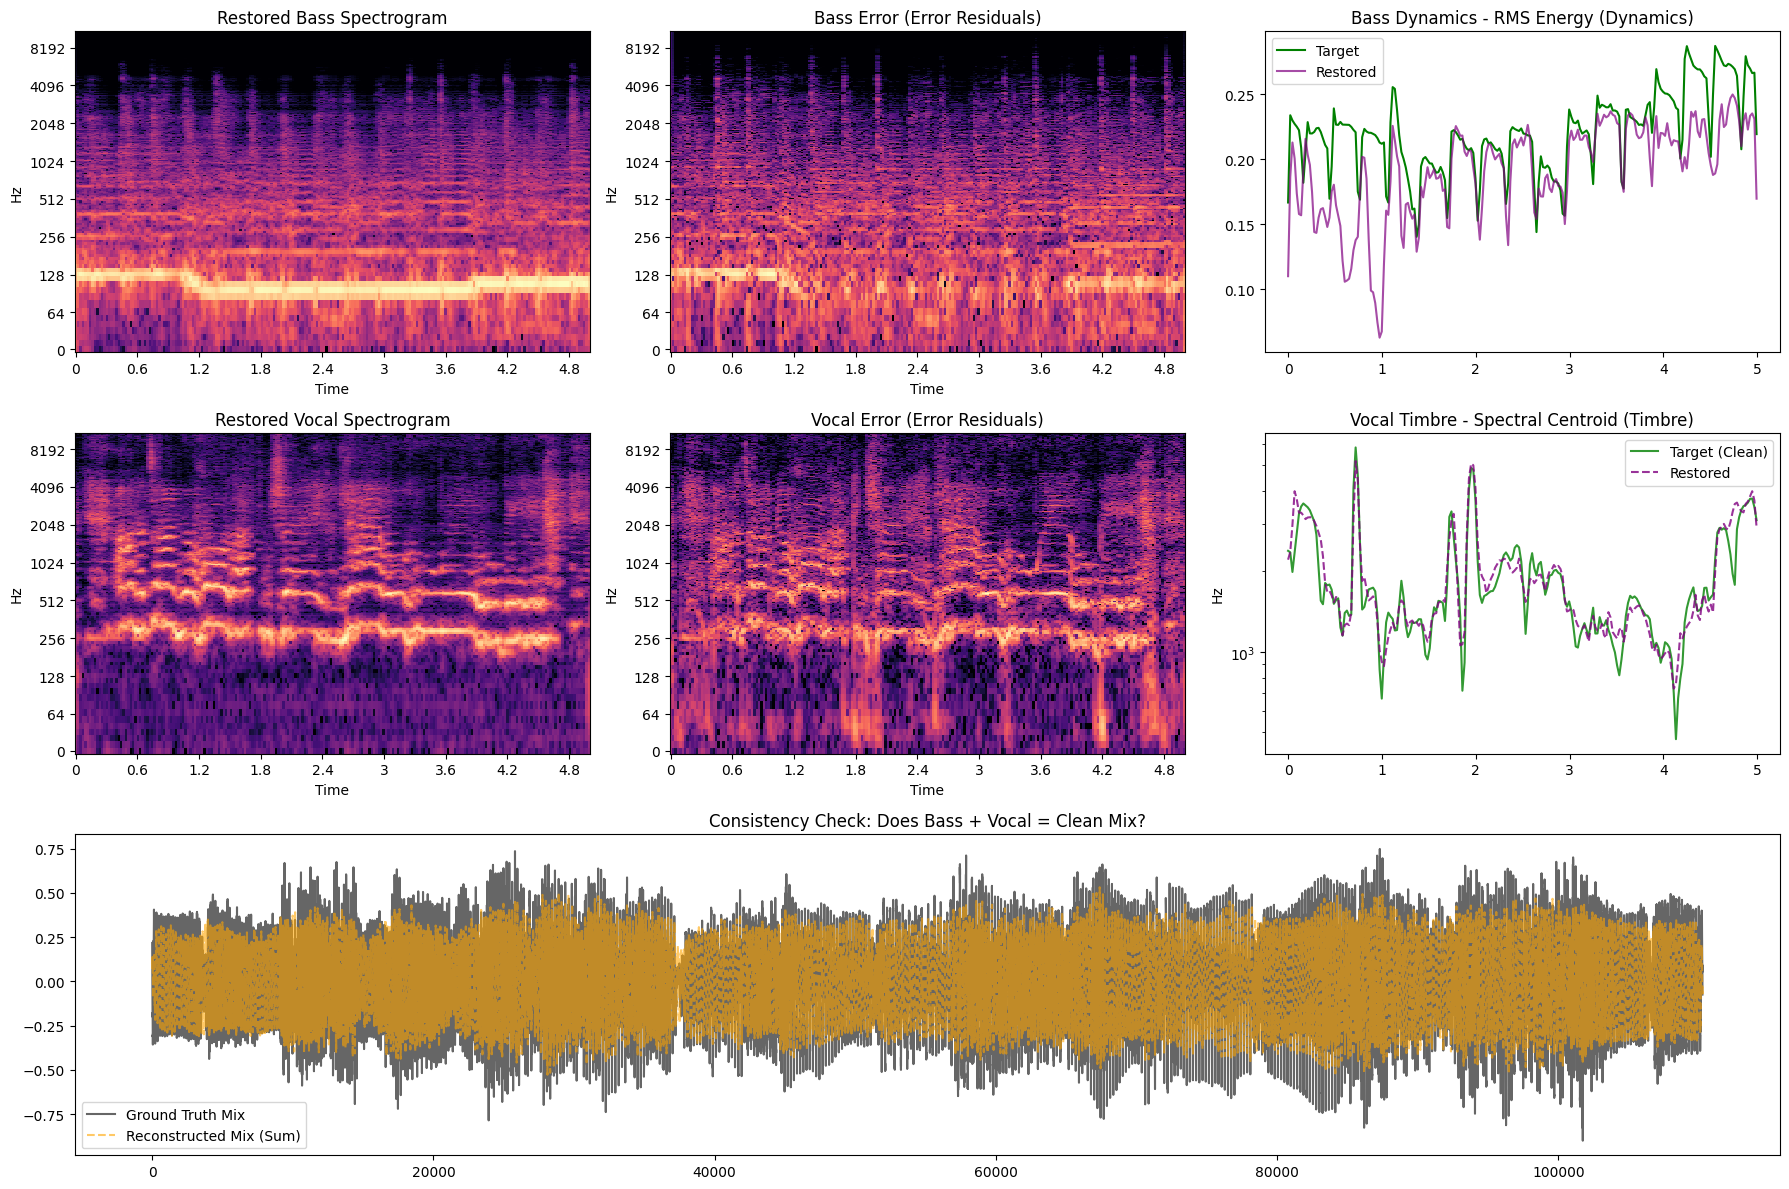

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
import scipy.stats

# --- CONFIG ---
MODEL_PATH = "advanced_unet_final.pth"
# Replace with a file from your 'cat4_both' (Reverb + Compression) folder
INPUT_FILE = "synthetic_dataset/inputs/cat4_both/mix_0004.wav"
# We need the ground truth to compare against
TARGET_BASS = "synthetic_dataset/targets/bass/mix_0004.wav"
TARGET_VOCAL = "synthetic_dataset/targets/vocals/mix_0004.wav"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SR = 22050

def compute_snr(target, estimate):
    """Computes Signal-to-Noise Ratio (higher is better)"""
    # Simple time-domain SNR
    s_target = np.sum(target ** 2)
    s_noise = np.sum((target - estimate) ** 2)
    return 10 * np.log10(s_target / (s_noise + 1e-7))

def plot_error_spec(ax, target, estimate, title):
    """Plots the magnitude difference between target and estimate"""
    D_target = np.abs(librosa.stft(target))
    D_estimate = np.abs(librosa.stft(estimate))

    # Calculate absolute difference
    diff = np.abs(D_target - D_estimate)
    diff_db = librosa.amplitude_to_db(diff, ref=np.max)

    img = librosa.display.specshow(diff_db, sr=SR, x_axis='time', y_axis='log', ax=ax, cmap='magma')
    ax.set_title(f"{title} (Error Residuals)")
    return img

def plot_spectral_centroid(ax, target, estimate, title):
    """Analyzes brightness/timbre over time"""
    cent_t = librosa.feature.spectral_centroid(y=target, sr=SR)[0]
    cent_e = librosa.feature.spectral_centroid(y=estimate, sr=SR)[0]
    frames = range(len(cent_t))
    t = librosa.frames_to_time(frames, sr=SR)

    ax.semilogy(t, cent_t, label='Target (Clean)', alpha=0.8, color='green')
    ax.semilogy(t, cent_e, label='Restored', alpha=0.8, color='purple', linestyle='--')
    ax.set_title(f"{title} - Spectral Centroid (Timbre)")
    ax.set_ylabel('Hz')
    ax.legend()

def plot_envelope(ax, target, estimate, title):
    """Analyzes Dynamic Range (Compression check)"""
    hop_length = 512
    frame_length = 1024

    rms_t = librosa.feature.rms(y=target, frame_length=frame_length, hop_length=hop_length)[0]
    rms_e = librosa.feature.rms(y=estimate, frame_length=frame_length, hop_length=hop_length)[0]

    frames = range(len(rms_t))
    t = librosa.frames_to_time(frames, sr=SR, hop_length=hop_length)

    ax.plot(t, rms_t, label='Target', color='green')
    ax.plot(t, rms_e, label='Restored', color='purple', alpha=0.7)
    ax.set_title(f"{title} - RMS Energy (Dynamics)")
    ax.legend()

def analyze_audio():
    print(f"--- Running Deep Analysis on {INPUT_FILE} ---")

    # 1. Load Audio
    if not os.path.exists(INPUT_FILE) or not os.path.exists(TARGET_BASS):
        print("Error: Input files not found. Check paths.")
        return

    mix_sig, _ = sf.read(INPUT_FILE)
    tb_sig, _ = sf.read(TARGET_BASS)
    tv_sig, _ = sf.read(TARGET_VOCAL)

    # 2. Run Inference
    print("Loading Model...")
    model = ImprovedMelUNet().to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()

    mix_tens = torch.from_numpy(mix_sig).float()
    if mix_tens.ndim == 1: mix_tens = mix_tens.unsqueeze(0)
    mix_tens = mix_tens.unsqueeze(0).to(DEVICE)

    print("Separating Sources...")
    with torch.no_grad():
        pb_tens, pv_tens, _, _ = model(mix_tens)

    pb_sig = pb_tens.squeeze().cpu().numpy()
    pv_sig = pv_tens.squeeze().cpu().numpy()

    # Ensure lengths match for metrics
    min_len = min(len(tb_sig), len(pb_sig))
    tb_sig, pb_sig = tb_sig[:min_len], pb_sig[:min_len]
    tv_sig, pv_sig = tv_sig[:min_len], pv_sig[:min_len]

    # 3. Compute Metrics
    snr_b = compute_snr(tb_sig, pb_sig)
    snr_v = compute_snr(tv_sig, pv_sig)
    print(f"\n--- Metrics ---")
    print(f"Bass SNR:   {snr_b:.2f} dB")
    print(f"Vocals SNR: {snr_v:.2f} dB")

    # 4. Generate Plot Grid
    # Rows: Bass Analysis, Vocal Analysis
    # Cols: Spectrogram Comparison, Error Map, Centroid/Dynamics
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3)

    # --- BASS ROW ---
    ax_b_spec = fig.add_subplot(gs[0, 0])
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(pb_sig)), ref=np.max), y_axis='log', x_axis='time', ax=ax_b_spec)
    ax_b_spec.set_title("Restored Bass Spectrogram")

    ax_b_err = fig.add_subplot(gs[0, 1])
    plot_error_spec(ax_b_err, tb_sig, pb_sig, "Bass Error")

    ax_b_dyn = fig.add_subplot(gs[0, 2])
    plot_envelope(ax_b_dyn, tb_sig, pb_sig, "Bass Dynamics")

    # --- VOCAL ROW ---
    ax_v_spec = fig.add_subplot(gs[1, 0])
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(pv_sig)), ref=np.max), y_axis='log', x_axis='time', ax=ax_v_spec)
    ax_v_spec.set_title("Restored Vocal Spectrogram")

    ax_v_err = fig.add_subplot(gs[1, 1])
    plot_error_spec(ax_v_err, tv_sig, pv_sig, "Vocal Error")

    ax_v_cen = fig.add_subplot(gs[1, 2])
    plot_spectral_centroid(ax_v_cen, tv_sig, pv_sig, "Vocal Timbre")

    # --- MIX / CONSISTENCY ROW ---
    ax_mix = fig.add_subplot(gs[2, :])
    # Check consistency: (Bass + Vocal) vs Original Clean Mix?
    # Or simply visualize waveforms
    ax_mix.plot(tb_sig + tv_sig, label="Ground Truth Mix", alpha=0.6, color='black')
    ax_mix.plot(pb_sig + pv_sig, label="Reconstructed Mix (Sum)", alpha=0.6, color='orange', linestyle='--')
    ax_mix.set_title("Consistency Check: Does Bass + Vocal = Clean Mix?")
    ax_mix.legend()

    plt.tight_layout()
    plt.savefig("deep_analysis_report.png")
    print("\nAnalysis Saved to 'deep_analysis_report.png'")

    try:
        plt.show()
    except:
        pass

if __name__ == "__main__":
    analyze_audio()

In [ ]:
import os
import shutil
import sys

def setup_drive_storage(project_name="Music_Restoration_Project"):
    """
    Mounts Google Drive and creates a dedicated folder for checkpoints.
    Returns the path to the persistent directory.
    """
    # 1. Check if running in Colab
    if 'google.colab' in sys.modules:
        from google.colab import drive
        print("Mounting Google Drive...")
        drive.mount('/content/drive')

        # 2. Define persistent path
        # This will be: /content/drive/MyDrive/Music_Restoration_Project/checkpoints
        drive_root = "/content/drive/MyDrive"
        persistent_dir = os.path.join(drive_root, project_name, "checkpoints")

        os.makedirs(persistent_dir, exist_ok=True)
        print(f"✅ Google Drive Mounted.")
        print(f"📂 Checkpoints will be saved to: {persistent_dir}")
        return persistent_dir
    else:
        print("Not running in Colab. Using local 'checkpoints' folder.")
        local_dir = "checkpoints"
        os.makedirs(local_dir, exist_ok=True)
        return local_dir

def backup_existing_weights(source_file, drive_folder):
    """
    Helper to copy a specific file (like your final model) to Drive immediately.
    """
    if not os.path.exists(source_file):
        print(f"File {source_file} does not exist.")
        return

    filename = os.path.basename(source_file)
    dest_path = os.path.join(drive_folder, filename)

    print(f"Backing up {filename} to Drive...")
    shutil.copy(source_file, dest_path)
    print(f"✅ Saved to {dest_path}")

if __name__ == "__main__":
    # Example Usage
    save_dir = setup_drive_storage()

Mounting Google Drive...
Mounted at /content/drive
✅ Google Drive Mounted.
📂 Checkpoints will be saved to: /content/drive/MyDrive/Music_Restoration_Project/checkpoints


In [ ]:
import os
import glob
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import random
from IPython.display import Audio, display

# ==========================================
# 1. SETUP & UNZIPPING (ROBUST VERSION)
# ==========================================
def setup_environment():
    print("--- 1. Setting up Environment ---")

    def safe_extract(zip_path, extract_to):
        if not os.path.exists(zip_path):
            print(f"⚠️ Warning: '{zip_path}' not found. Skipping.")
            return False

        try:
            with zipfile.ZipFile(zip_path, 'r') as z:
                # Test zip integrity first
                test = z.testzip()
                if test is not None:
                    print(f"❌ Error: '{zip_path}' is corrupted (File: {test}).")
                    return False

                print(f"Extracting {zip_path}...")
                z.extractall(extract_to)
                return True
        except zipfile.BadZipFile:
            print(f"❌ Critical Error: '{zip_path}' is not a valid zip file.")
            print(f"   Action: Please delete '{zip_path}' from Colab and re-upload it.")
            return False
        except Exception as e:
            print(f"❌ Unknown error extracting {zip_path}: {e}")
            return False

    # 1. Unzip Weights
    if not safe_extract("checkpoints.zip", "."):
        print("   (Proceeding without new checkpoints if they fail...)")

    # 2. Unzip Clean Stems
    for target in ["bass_target.zip", "vocals_target.zip"]:
        name = target.split('_')[0] # 'bass' or 'vocals'
        safe_extract(target, f"raw_stems/{name}")

    # 3. Unzip Synthetic Dataset
    syn_zips = glob.glob("synthetic_dataset*.zip")
    if syn_zips:
        target_zip = sorted(syn_zips)[-1]
        safe_extract(target_zip, ".")
    else:
        print("⚠️ Warning: No 'synthetic_dataset*.zip' found. Make sure you uploaded it.")

# ==========================================
# 2. MODEL ARCHITECTURE (Must match training)
# ==========================================
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1, padding_mode='reflect')
        self.bn1 = nn.BatchNorm2d(channels)
        self.act = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1, padding_mode='reflect')
        self.bn2 = nn.BatchNorm2d(channels)
        self.ca = ChannelAttention(channels)
    def forward(self, x):
        res = self.conv1(x)
        res = self.bn1(res)
        res = self.act(res)
        res = self.conv2(res)
        res = self.bn2(res)
        res = self.ca(res)
        return x + res

class FourierLayer(nn.Module):
    def __init__(self, n_fft, hop_length):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.window = nn.Parameter(torch.hann_window(n_fft), requires_grad=False)
    def stft(self, x):
        x = x.squeeze(1)
        s = torch.stft(x, self.n_fft, self.hop_length, window=self.window, return_complex=True)
        return torch.view_as_real(s).permute(0, 3, 1, 2)
    def istft(self, x, length):
        x = x.permute(0, 2, 3, 1)
        c = torch.complex(x[..., 0], x[..., 1])
        return torch.istft(c, self.n_fft, self.hop_length, window=self.window, length=length).unsqueeze(1)

class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 4, 2, 1),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )
    def forward(self, x):
        return self.block(x)

class ImprovedMelUNet(nn.Module):
    def __init__(self, n_fft=1024, hop_length=256):
        super().__init__()
        self.fourier = FourierLayer(n_fft, hop_length)

        self.in_conv = nn.Conv2d(2, 32, 7, 1, 3)
        self.d1 = nn.Sequential(nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2))
        self.d2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        self.d3 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
        self.d4 = nn.Sequential(nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2))

        self.neck = nn.Sequential(ResBlock(512), ResBlock(512))

        self.u4_b = DecoderBlock(512, 256)
        self.u3_b = DecoderBlock(512, 128)
        self.u2_b = DecoderBlock(256, 64)
        self.u1_b = DecoderBlock(128, 32)
        self.out_b = nn.Conv2d(64, 2, 3, 1, 1)

        self.u4_v = DecoderBlock(512, 256)
        self.u3_v = DecoderBlock(512, 128)
        self.u2_v = DecoderBlock(256, 64)
        self.u1_v = DecoderBlock(128, 32)
        self.out_v = nn.Conv2d(64, 2, 3, 1, 1)

        self.final_act = nn.Tanh()

    def pad_to_match(self, src, target):
        if src.shape[-2:] != target.shape[-2:]:
            return F.interpolate(src, size=target.shape[-2:], mode='nearest')
        return src

    def forward_decoder(self, neck, skips):
        c4, c3, c2, c1, inp = skips

        # Bass
        b4 = self.pad_to_match(self.u4_b(neck), c4)
        b3 = self.pad_to_match(self.u3_b(torch.cat([b4, c4], dim=1)), c3)
        b2 = self.pad_to_match(self.u2_b(torch.cat([b3, c3], dim=1)), c2)
        b1 = self.pad_to_match(self.u1_b(torch.cat([b2, c2], dim=1)), c1)
        bass_out = self.out_b(torch.cat([b1, c1], dim=1))

        # Vocal
        v4 = self.pad_to_match(self.u4_v(neck), c4)
        v3 = self.pad_to_match(self.u3_v(torch.cat([v4, c4], dim=1)), c3)
        v2 = self.pad_to_match(self.u2_v(torch.cat([v3, c3], dim=1)), c2)
        v1 = self.pad_to_match(self.u1_v(torch.cat([v2, c2], dim=1)), c1)
        vocal_out = self.out_v(torch.cat([v1, c1], dim=1))

        return bass_out, vocal_out

    def forward(self, x):
        original_length = x.shape[-1]
        x_spec = self.fourier.stft(x)

        c1 = self.in_conv(x_spec)
        c2 = self.d1(c1)
        c3 = self.d2(c2)
        c4 = self.d3(c3)
        c5 = self.d4(c4)
        neck = self.neck(c5)

        bass_spec, vocal_spec = self.forward_decoder(neck, [c4, c3, c2, c1, c1])

        bass_wav = self.fourier.istft(bass_spec, original_length)
        vocal_wav = self.fourier.istft(vocal_spec, original_length)

        return self.final_act(bass_wav), self.final_act(vocal_wav), bass_spec, vocal_spec

# ==========================================
# 3. ANALYSIS & VISUALIZATION UTILS
# ==========================================
def compute_snr(target, estimate):
    # Scale invariant SNR
    target = target - np.mean(target)
    estimate = estimate - np.mean(estimate)
    s_target = np.sum(target ** 2)
    s_noise = np.sum((target - estimate) ** 2)
    return 10 * np.log10(s_target / (s_noise + 1e-7))

def show_spec(ax, sig, title, sr=22050):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(sig)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=ax)
    ax.set_title(title)

# ==========================================
# 4. MAIN TESTING LOOP
# ==========================================
def run_full_test():
    # A. Setup
    setup_environment()
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Running on {DEVICE}")

    # B. Locate Model weights
    # Try finding final model, otherwise pick latest epoch
    weight_path = "advanced_unet_final.pth"
    if not os.path.exists(weight_path):
        # Look in checkpoints folder if unzipped there
        ckpts = glob.glob("checkpoints/*.pth")
        if ckpts:
            weight_path = sorted(ckpts)[-1]
        else:
            # Fallback: check recursive search in case unzip created subfolder
            rec_ckpts = glob.glob("**/*.pth", recursive=True)
            if rec_ckpts:
                weight_path = sorted(rec_ckpts)[-1]
            else:
                print("❌ Critical: No model weights (.pth) found.")
                return

    print(f"Loading weights from: {weight_path}")
    model = ImprovedMelUNet().to(DEVICE)
    try:
        model.load_state_dict(torch.load(weight_path, map_location=DEVICE))
    except Exception as e:
        print(f"Error loading weights: {e}")
        return

    model.eval()

    # C. Locate Test File
    # We look for inputs in the 'cat4_both' folder (Hardest difficulty)
    # Handle potentially different unzip paths
    input_pattern = "synthetic_dataset*/inputs/cat4_both/*.wav"
    test_files = glob.glob(input_pattern)

    # Fallback search if path structure is slightly different
    if not test_files:
        test_files = glob.glob("**/inputs/cat4_both/*.wav", recursive=True)

    if not test_files:
        print(f"❌ No test files found. Ensure 'synthetic_dataset' extracted correctly.")
        return

    # Pick random file
    input_file = random.choice(test_files)
    fname = os.path.basename(input_file)
    print(f"🎵 Testing on: {fname}")

    # D. Load Audio (Handle paths dynamically)
    # The structure is standard, so we infer targets from input path
    # Input: .../inputs/cat4_both/mix_0000.wav
    # Target: .../targets/bass/mix_0000.wav

    base_dir = input_file.split("inputs")[0] # Get root of dataset
    path_mix_deg = input_file
    path_bass_gt = os.path.join(base_dir, "targets", "bass", fname)
    path_vocal_gt = os.path.join(base_dir, "targets", "vocals", fname)
    path_mix_cln = os.path.join(base_dir, "targets", "mix", fname)

    try:
        sig_mix_deg, sr = sf.read(path_mix_deg)
        if os.path.exists(path_bass_gt):
            sig_bass_gt, _ = sf.read(path_bass_gt)
            sig_vocal_gt, _ = sf.read(path_vocal_gt)
            sig_mix_cln, _ = sf.read(path_mix_cln)
        else:
            print("⚠️ Targets not found. Showing predictions only.")
            sig_bass_gt = np.zeros_like(sig_mix_deg)
            sig_vocal_gt = np.zeros_like(sig_mix_deg)
            sig_mix_cln = np.zeros_like(sig_mix_deg)

    except Exception as e:
        print(f"Error loading audio files: {e}")
        return

    # E. Inference
    inp_tensor = torch.from_numpy(sig_mix_deg).float()
    if inp_tensor.ndim == 1: inp_tensor = inp_tensor.unsqueeze(0)
    inp_tensor = inp_tensor.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred_bass, pred_vocal, _, _ = model(inp_tensor)

    sig_bass_pred = pred_bass.squeeze().cpu().numpy()
    sig_vocal_pred = pred_vocal.squeeze().cpu().numpy()

    # F. Metrics
    snr_b = compute_snr(sig_bass_gt, sig_bass_pred)
    snr_v = compute_snr(sig_vocal_gt, sig_vocal_pred)
    print(f"\n📊 RESULTS:")
    print(f"Bass SNR: {snr_b:.2f} dB")
    print(f"Vocal SNR: {snr_v:.2f} dB")

    # G. Visualization
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(4, 3)

    # Row 1: Inputs vs Targets (Spec)
    ax = fig.add_subplot(gs[0, 0]); show_spec(ax, sig_mix_deg, "Input (Reverb+Comp)")
    ax = fig.add_subplot(gs[0, 1]); show_spec(ax, sig_bass_gt, "Target Bass")
    ax = fig.add_subplot(gs[0, 2]); show_spec(ax, sig_vocal_gt, "Target Vocals")

    # Row 2: Outputs (Spec)
    ax = fig.add_subplot(gs[1, 0]); show_spec(ax, sig_mix_cln, "Target Mix (Clean)")
    ax = fig.add_subplot(gs[1, 1]); show_spec(ax, sig_bass_pred, "Restored Bass")
    ax = fig.add_subplot(gs[1, 2]); show_spec(ax, sig_vocal_pred, "Restored Vocals")

    # Row 3: Waveforms (Bass)
    ax = fig.add_subplot(gs[2, :])
    ax.plot(sig_bass_gt, label="Ground Truth", alpha=0.7, color='green')
    ax.plot(sig_bass_pred, label="Prediction", alpha=0.7, color='purple', linestyle='--')
    ax.set_title(f"Bass Waveform Comparison (SNR: {snr_b:.2f}dB)")
    ax.legend()

    # Row 4: Waveforms (Vocals)
    ax = fig.add_subplot(gs[3, :])
    ax.plot(sig_vocal_gt, label="Ground Truth", alpha=0.7, color='blue')
    ax.plot(sig_vocal_pred, label="Prediction", alpha=0.7, color='orange', linestyle='--')
    ax.set_title(f"Vocal Waveform Comparison (SNR: {snr_v:.2f}dB)")
    ax.legend()

    plt.tight_layout()
    plt.show()

    # H. Audio Player
    print("\n🎧 LISTEN TO RESULTS:")
    print("1. Degraded Input (Mix + Reverb + Comp):")
    display(Audio(sig_mix_deg, rate=sr))

    print("2. Restored BASS:")
    display(Audio(sig_bass_pred, rate=sr))

    print("3. Restored VOCALS:")
    display(Audio(sig_vocal_pred, rate=sr))

    print("4. Target BASS (Clean):")
    display(Audio(sig_bass_gt, rate=sr))

if __name__ == "__main__":
    run_full_test()

--- 1. Setting up Environment ---
Extracting checkpoints.zip...
Extracting bass_target.zip...
❌ Critical Error: 'vocals_target.zip' is not a valid zip file.
   Action: Please delete 'vocals_target.zip' from Colab and re-upload it.
Extracting synthetic_dataset_restoration 5.56.48 PM.zip...
Running on cpu
❌ Critical: No model weights (.pth) found.
